<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/5.%201Q%20DD%20(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [2]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 28.1 MB/s eta 0:00:00


In [3]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# CP CPMG UDD XY4 XY8 XY16 Sequence

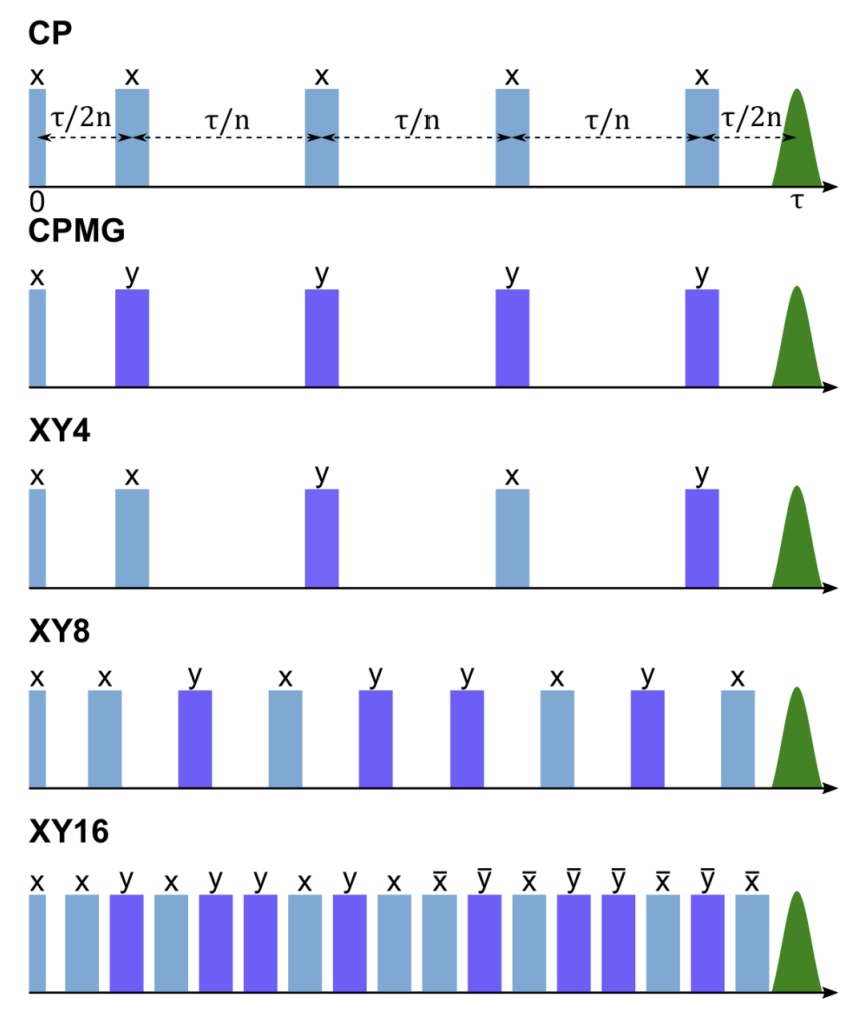

In [309]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [310]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [311]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

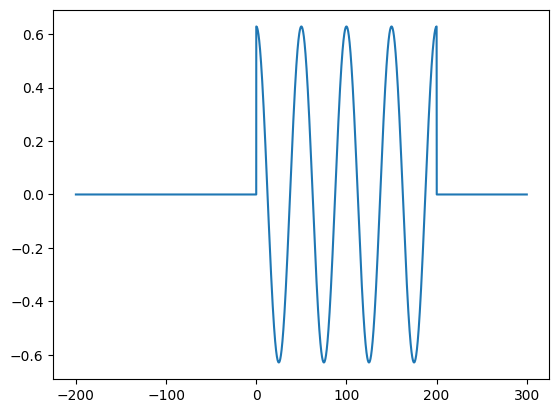

In [312]:
# resonator drive pulse simulation

tlist = np.linspace(-200, 300, 10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': 0, 'T_end_r': 200, 'Omega_rd': 2*np.pi*0.02}))

## CP CPMG UDD Sequence

In [313]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [314]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [315]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

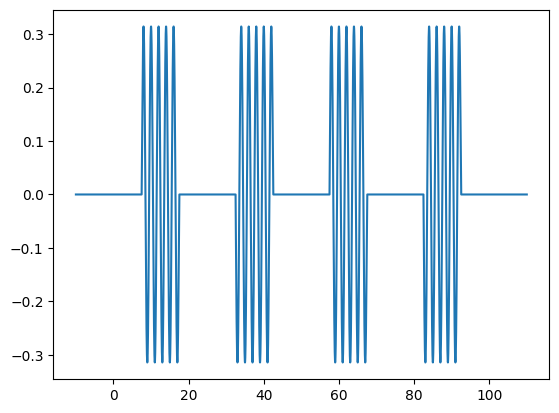

In [316]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

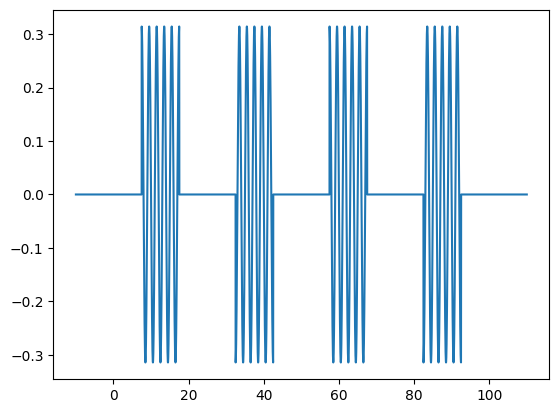

In [317]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

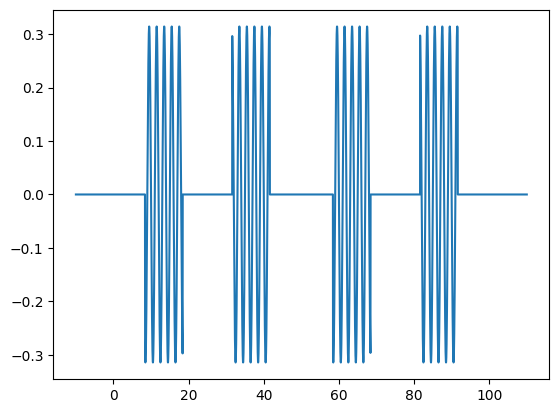

In [318]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

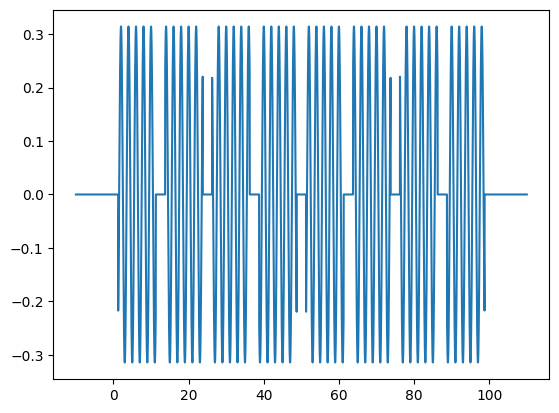

In [319]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

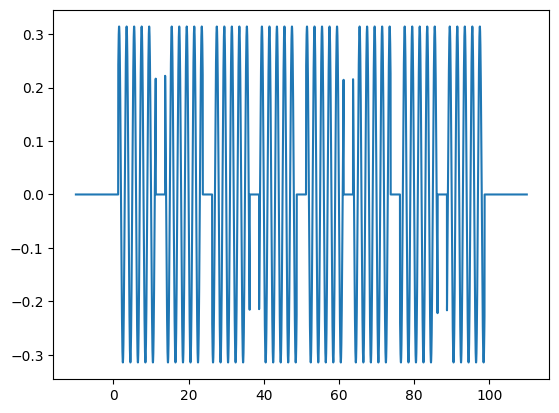

In [320]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

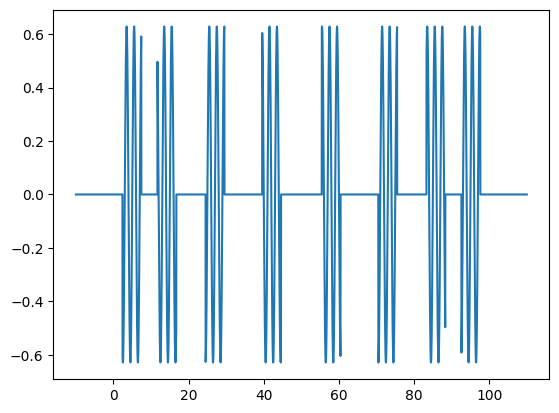

In [321]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

## XY4 XY8 XY16 Sequence

In [322]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [323]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [324]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

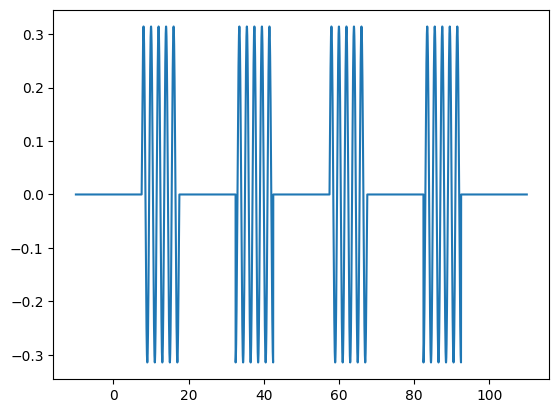

In [325]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

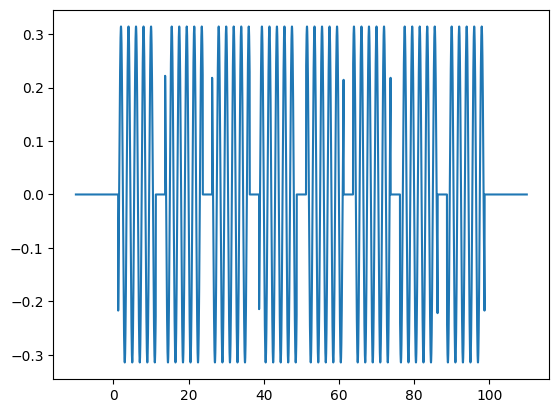

In [326]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY8_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

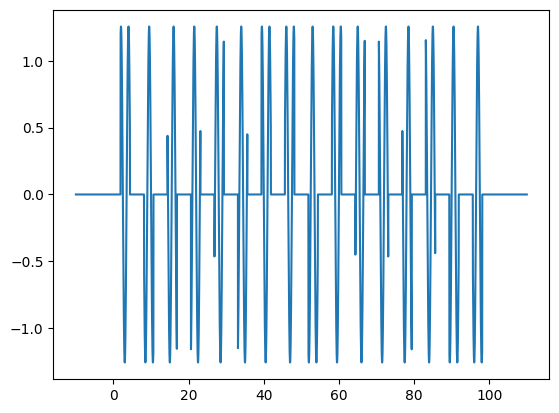

In [327]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

## UDD4 UDD8 UDD16 Sequence

In [328]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [329]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [330]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

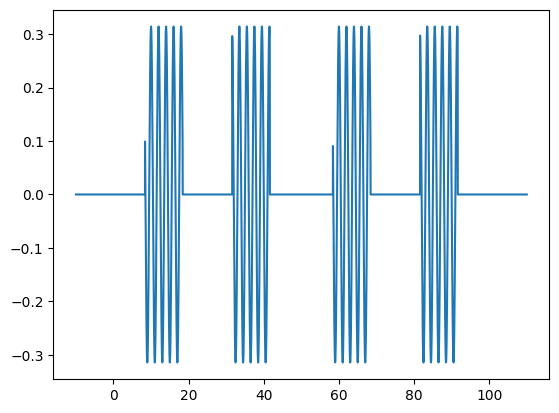

In [331]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

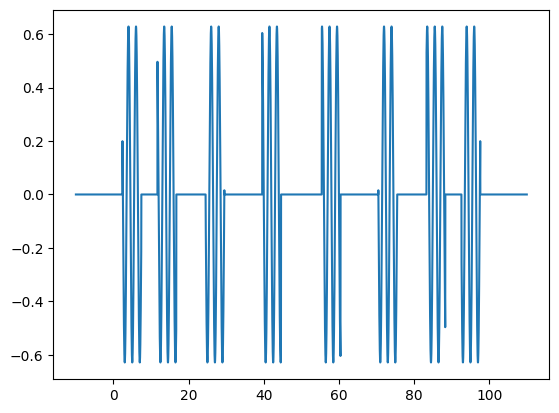

In [332]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD8_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

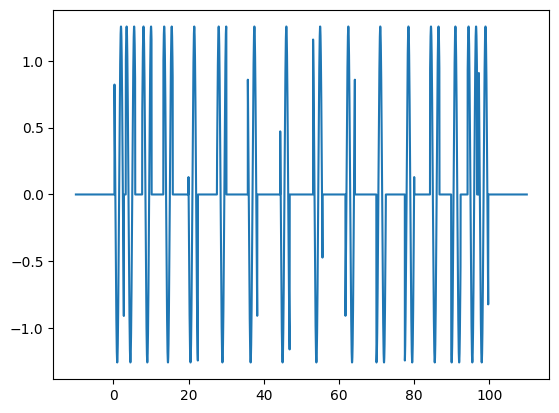

In [333]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

# Goal of this paper

Goal : Investigate the effect of dynamical decoupling

Total evolution time : 500ns, 1000ns

Condition 1 : large photon number regime $ n = 0.005 $

Condition 2 : without Purcell Filter

# Ramsey Simulation & Coherence Signal Analysis (Thermal Photon Case)

Without Purcell Filter

Evolution time 500ns

## Ramsey (n_th = 0)

In [341]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
# H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

B = 0.1 * 2 * np.pi

In [342]:
# Simulation

N_seq = 0
n_th = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa*(n_th+1)) * tensor(qeye(2), a), np.sqrt(kappa*(n_th)) * tensor(qeye(2), a.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.004348998234429389


Text(0, 0.5, 'Z Expectation Value')

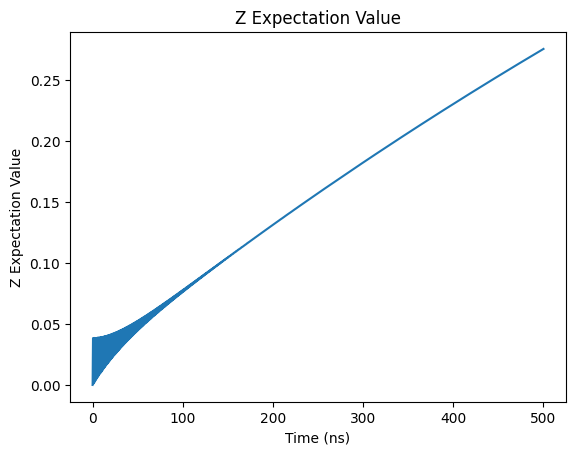

In [343]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [344]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.66488803e-01,  9.85712459e-01,  1.61994919e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

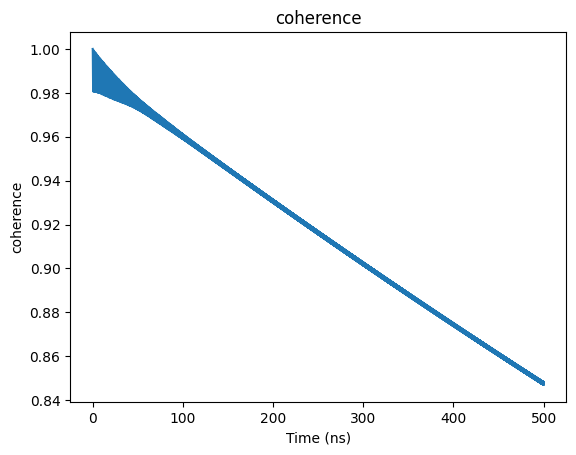

In [345]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

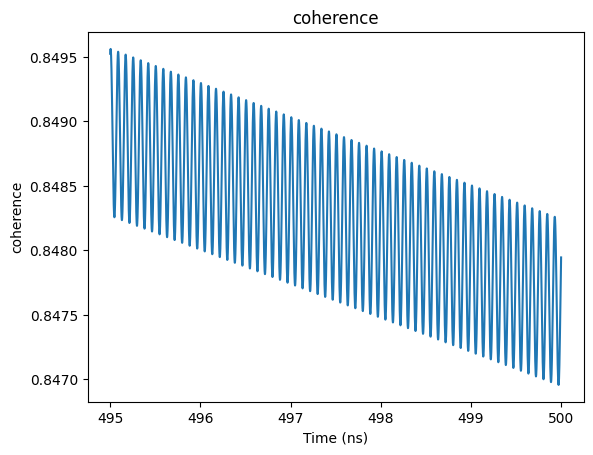

In [346]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

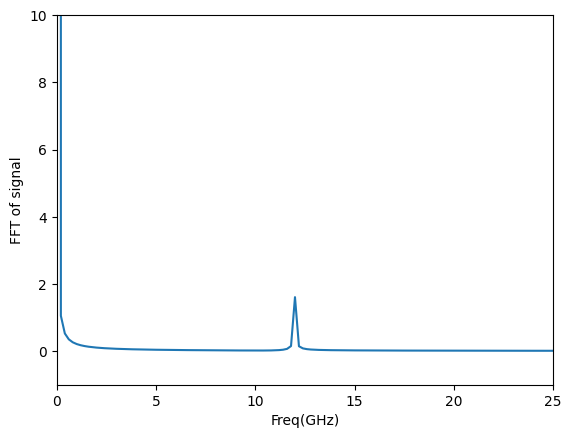

In [347]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

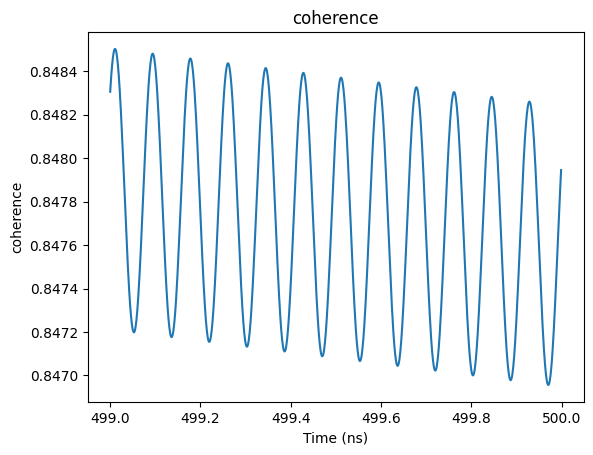

In [348]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

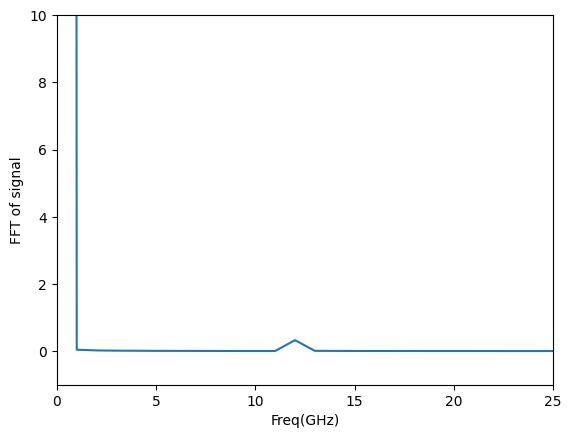

In [349]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

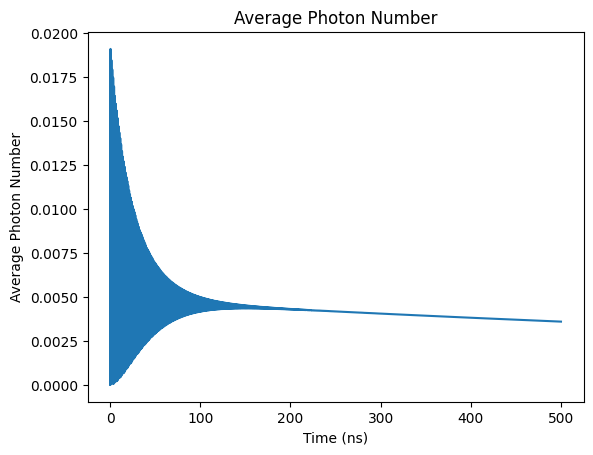

In [350]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

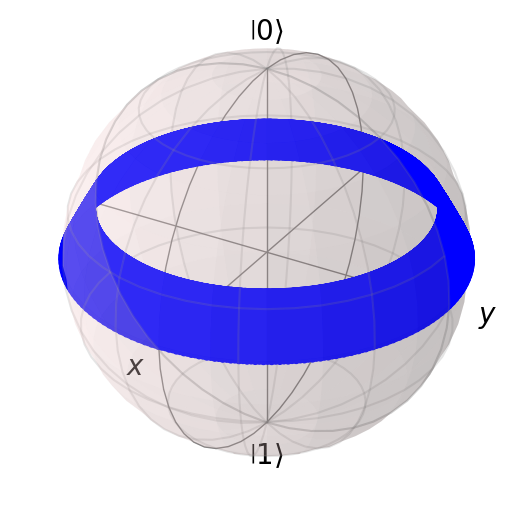

In [351]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.01)

In [352]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
# H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

B = 0.1 * 2 * np.pi

In [353]:
# Simulation

N_seq = 0
n_th = 0.01

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa*(n_th+1)) * tensor(qeye(2), a), np.sqrt(kappa*(n_th)) * tensor(qeye(2), a.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.014016283447976553


Text(0, 0.5, 'Z Expectation Value')

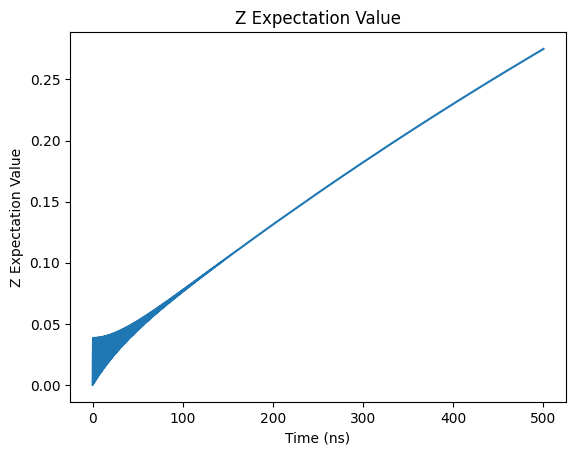

In [354]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [355]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.47270664e-01,  9.66493683e-01,  1.58919495e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

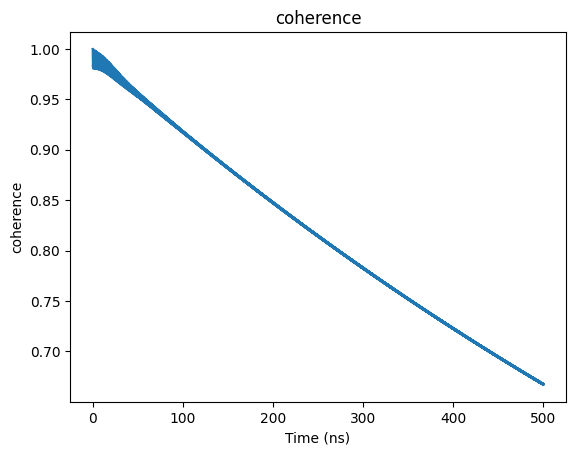

In [356]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

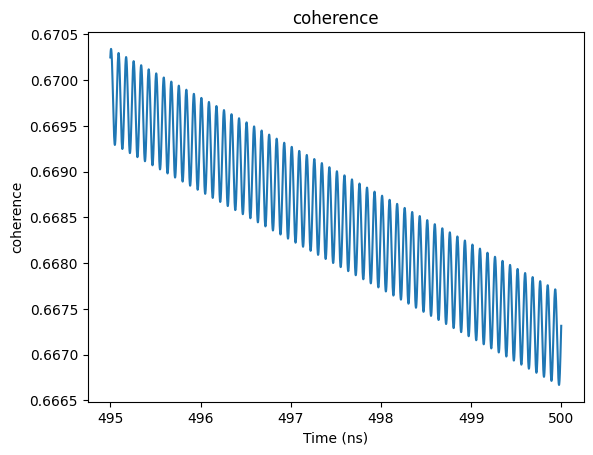

In [357]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

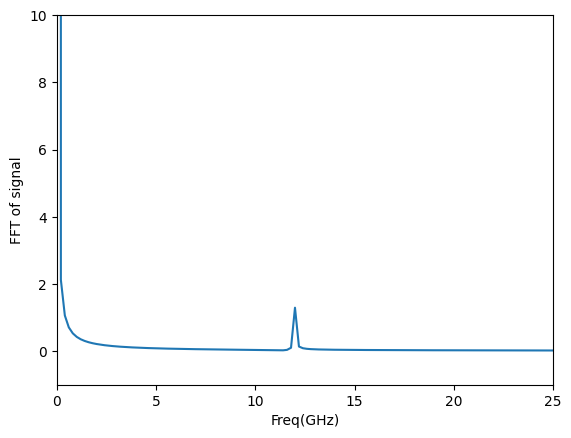

In [358]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

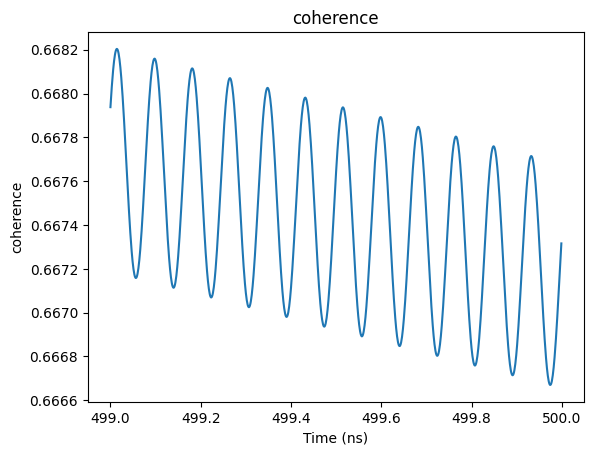

In [359]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

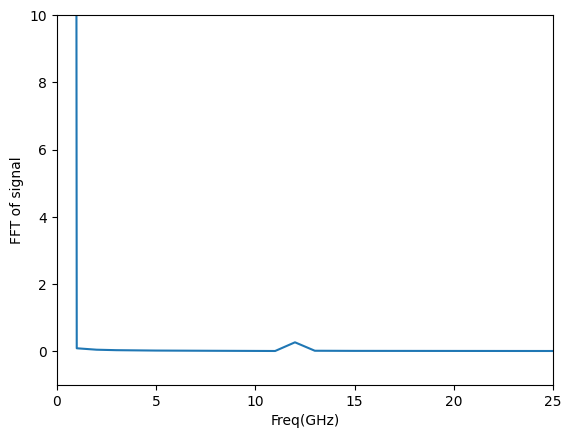

In [360]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

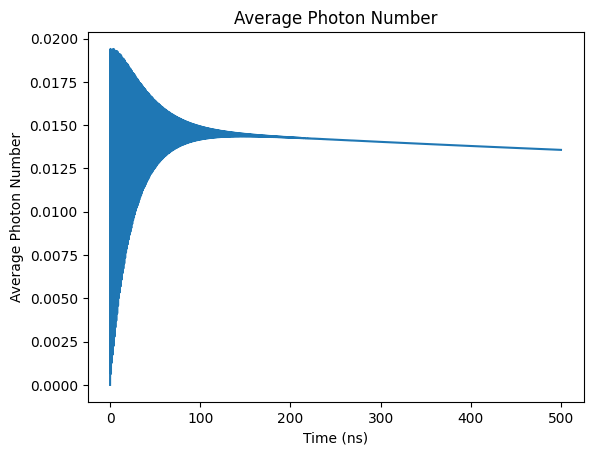

In [361]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

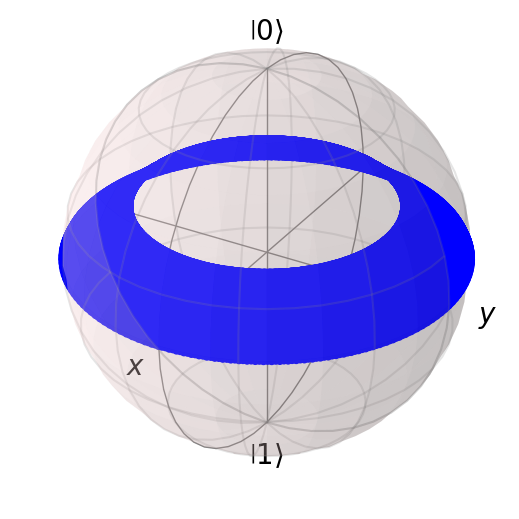

In [362]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.02)

In [385]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
# H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

B = 0.1 * 2 * np.pi

In [386]:
# Simulation

N_seq = 0
n_th = 0.02

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa*(n_th+1)) * tensor(qeye(2), a), np.sqrt(kappa*(n_th)) * tensor(qeye(2), a.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.023683628700621757


Text(0, 0.5, 'Z Expectation Value')

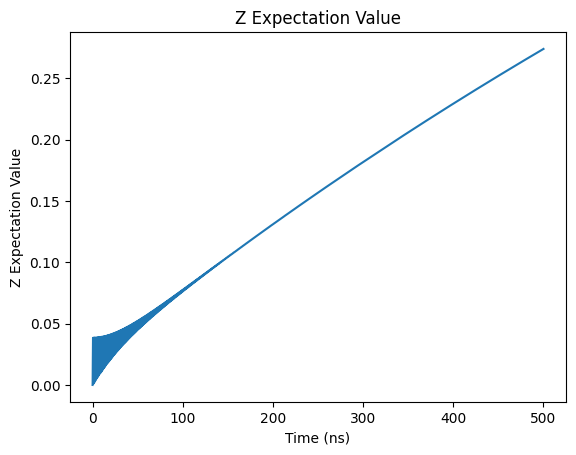

In [387]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [388]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.28788244e-01,  9.48010597e-01,  1.55961540e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

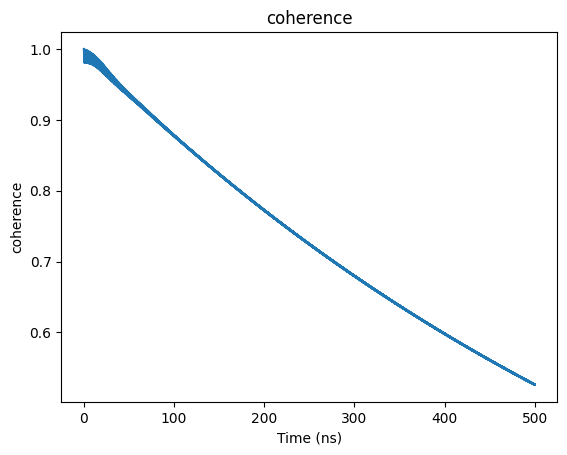

In [389]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

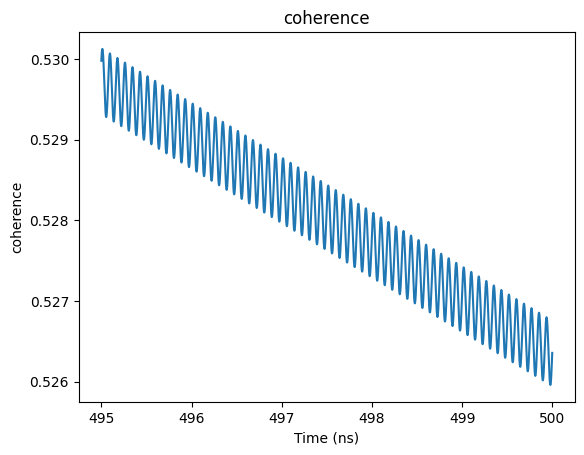

In [390]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

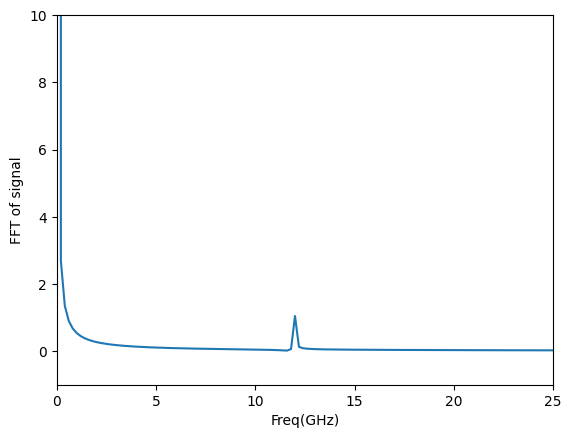

In [391]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

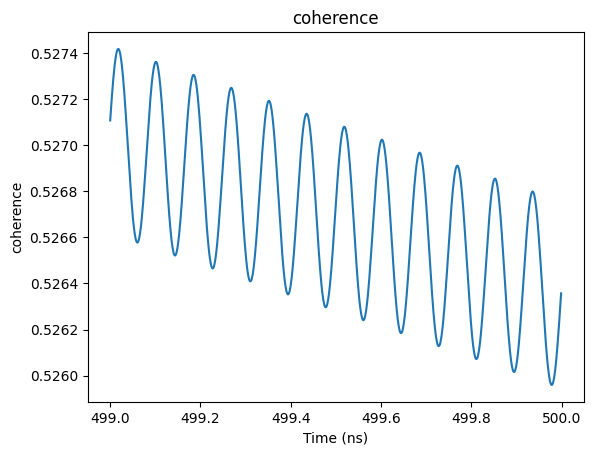

In [392]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

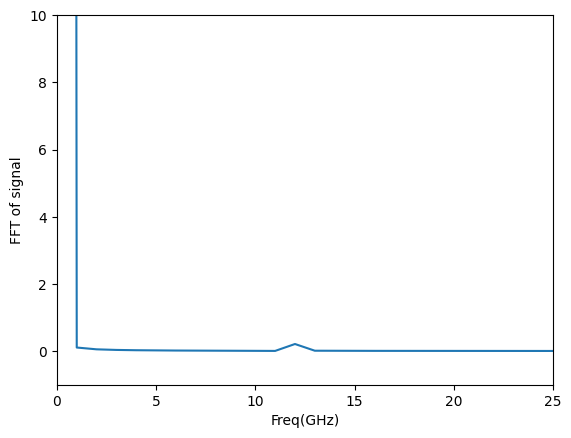

In [393]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

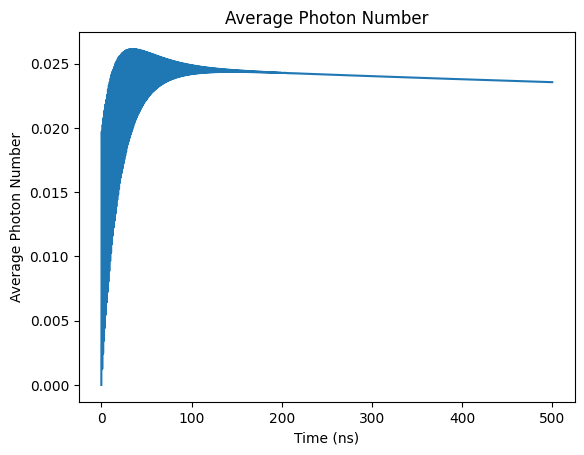

In [394]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

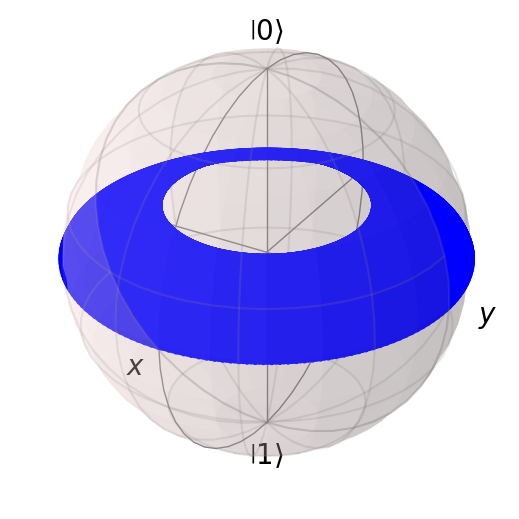

In [395]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.05)

In [363]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
# H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

B = 0.1 * 2 * np.pi

In [364]:
# Simulation

N_seq = 0
n_th = 0.05

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa*(n_th+1)) * tensor(qeye(2), a), np.sqrt(kappa*(n_th)) * tensor(qeye(2), a.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.05268493485936377


Text(0, 0.5, 'Z Expectation Value')

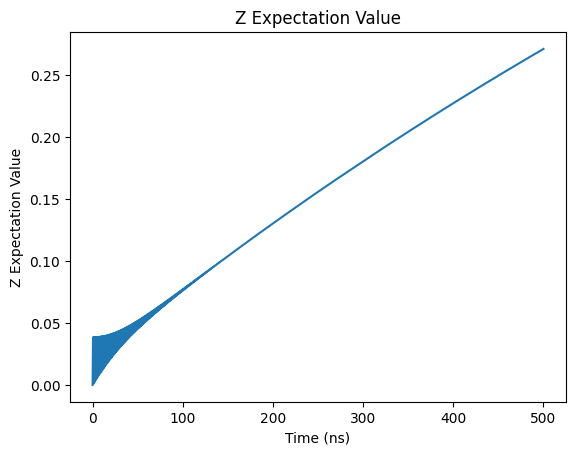

In [365]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [366]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-8.77375275e-01,  8.96594747e-01,  1.47725579e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

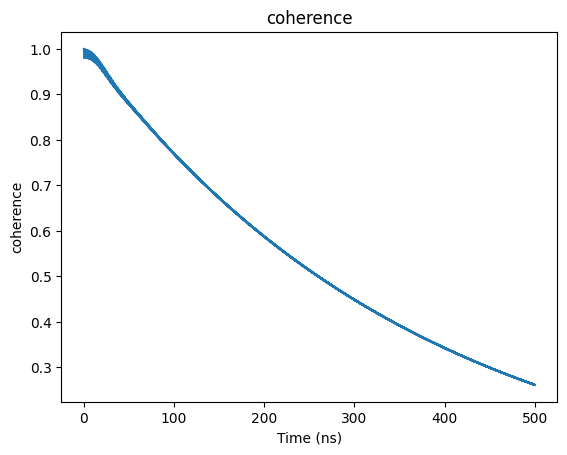

In [367]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

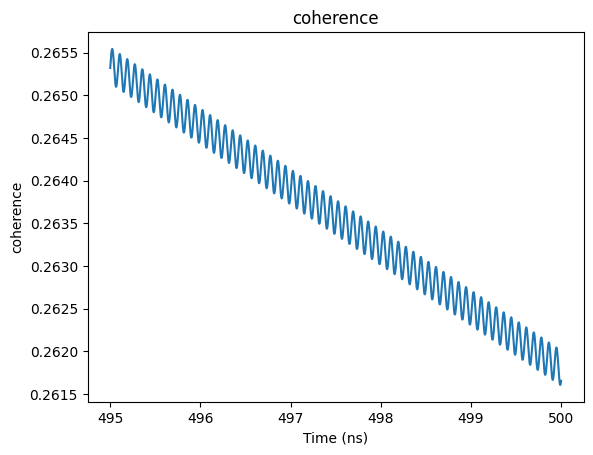

In [368]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

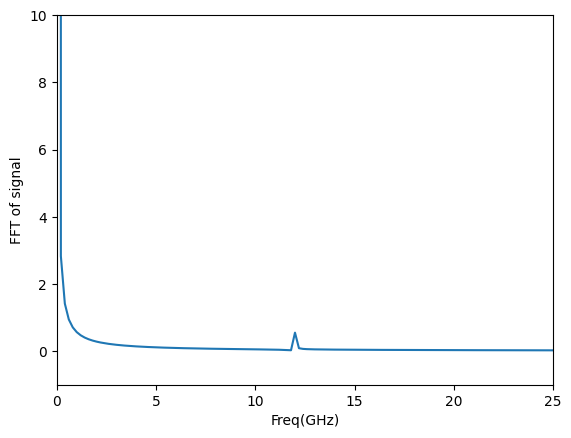

In [369]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

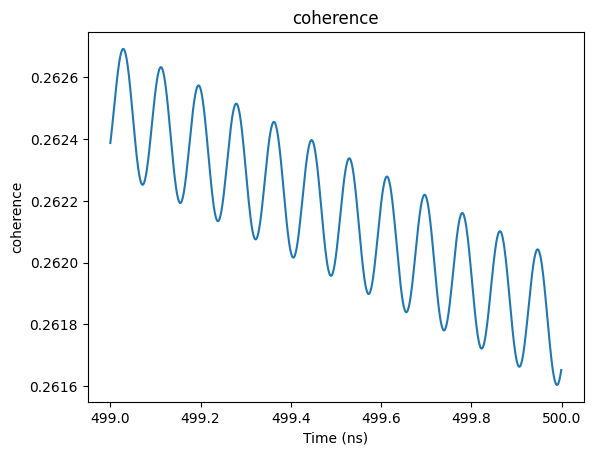

In [370]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

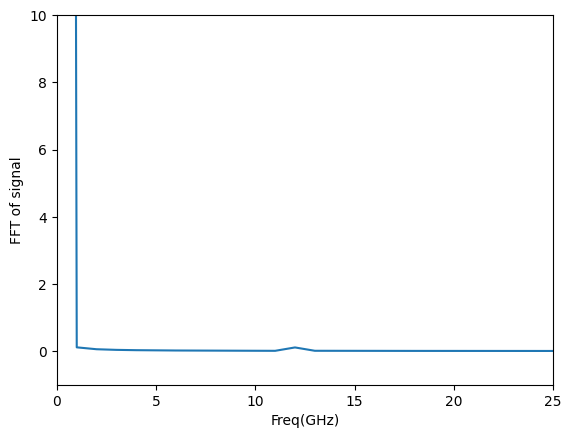

In [371]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

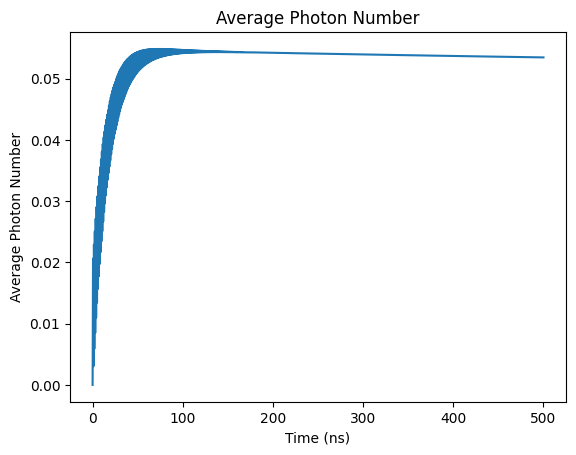

In [372]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

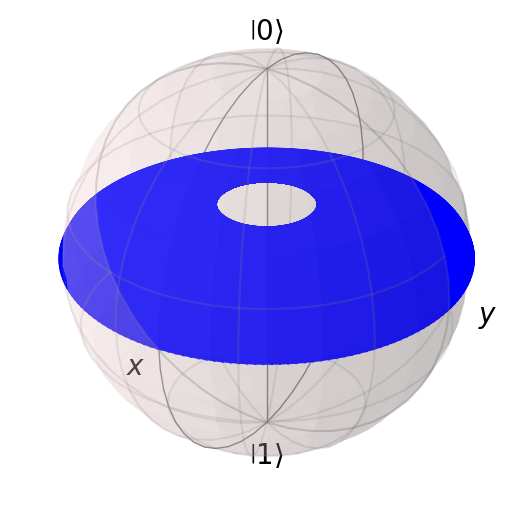

In [373]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.10)

In [374]:
N = 5

omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0     # qubit frequency in units of GHz

g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # resonator linewidth in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r            # qubit frequency in units of GHz
omega_qd = omega_q            # qubit frequency in units of GHz

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

tlist = np.linspace(0, 500, 500000)
T_end_q = 500

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = -0.5*omega_q*sz_composite + omega_r*number_composite + g*tensor(sx, a + a.dag())
# H1 = tensor(qeye(2), a + a.dag())
H2 = sx_composite

B = 0.1 * 2 * np.pi

In [375]:
# Simulation

N_seq = 0
n_th = 0.10

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa*(n_th+1)) * tensor(qeye(2), a), np.sqrt(kappa*(n_th)) * tensor(qeye(2), a.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.10099533336814015


Text(0, 0.5, 'Z Expectation Value')

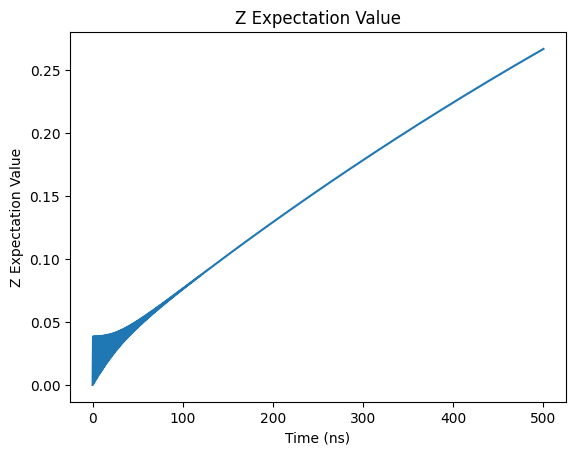

In [376]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [377]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-8.03264898e-01,  8.22469972e-01,  1.35772929e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

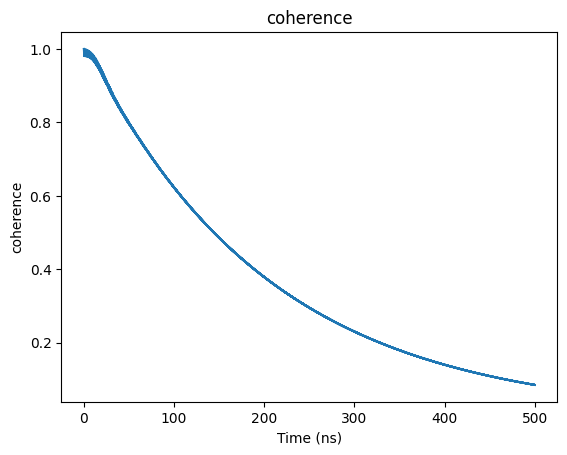

In [378]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'coherence')

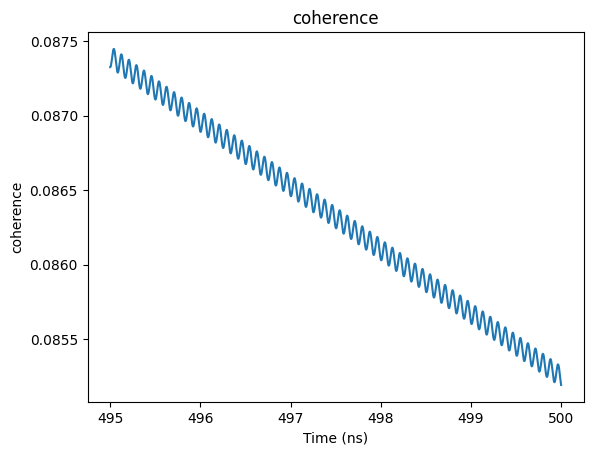

In [379]:
# Plot Results

plt.plot(tlist[-5001:-1], 2*np.abs(result.expect[3][-5001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

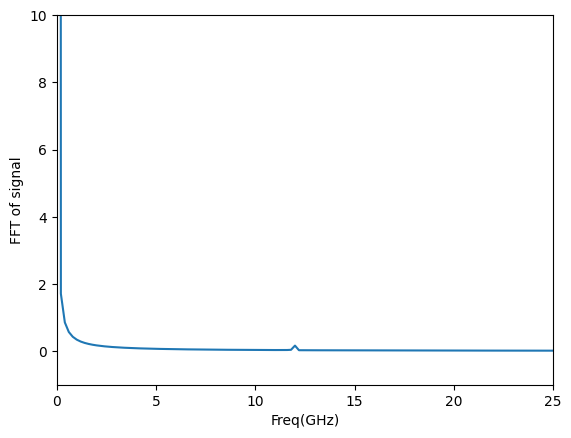

In [380]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-5001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-5001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'coherence')

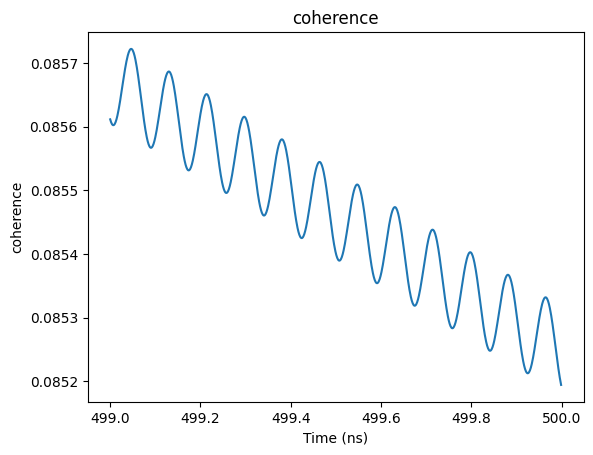

In [381]:
# Plot Results

plt.plot(tlist[-1001:-1], 2*np.abs(result.expect[3][-1001:-1]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'FFT of signal')

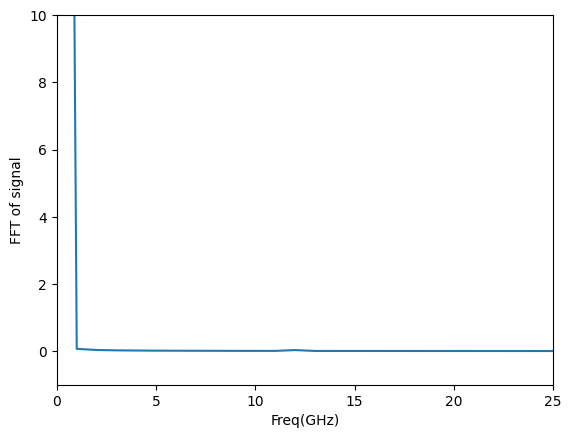

In [382]:
coherence_fft = np.fft.fftshift(np.fft.fft(2*np.abs(result.expect[3][-1001:-1])))
coherence_freq = np.fft.fftshift(np.fft.fftfreq(len(2*np.abs(result.expect[3][-1001:-1])), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(coherence_freq, np.abs(coherence_fft))
plt.xlim(0,25)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')

Text(0, 0.5, 'Average Photon Number')

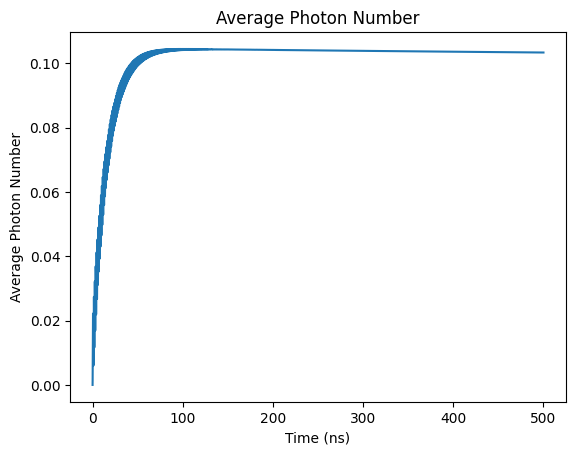

In [383]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

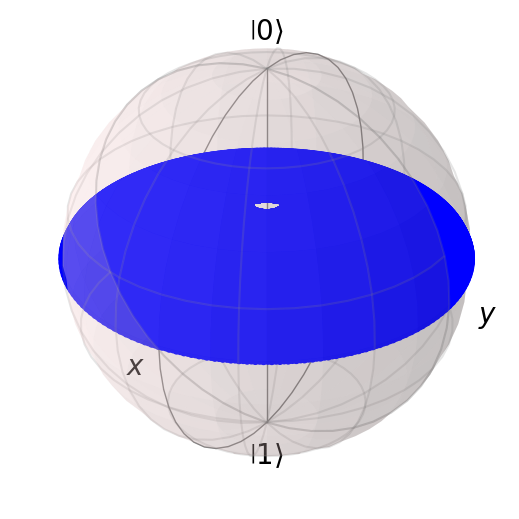

In [384]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

# Ramsey Simulation & Photon Number Calculation (Thermal Photon Case)

With Purcell Filter

Evolution time 500ns

In [146]:
nth_list = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13]

In [147]:
n_list = []

In [262]:
n_list

[0.00798522851099307,
 0.017015670421969924,
 0.025721601622787638,
 0.034120124844334354,
 0.0422271679665512,
 0.05005758261153177,
 0.057625233036684764,
 0.06494307641510726,
 0.07202323545446147,
 0.0788770641883869,
 0.08551520767305751,
 0.09194765623366859,
 0.09818379482936314,
 0.1042324480387417]

[0.00798522851099307,
 0.008004399744174856,
 0.00836499926305596,
 0.0099214351470651,
 0.01404443850917891,
 0.022463949674930914,
 0.03694191539012318,
 0.05876942996147742,
 0.08822084696907329,
 0.12424001012449509,
 0.1645887758015602,
 0.2075442368201584,
 0.24823480383925112,
 0.2857583013724545,
 0.31901806526561194,
 0.3476606670828996,]

Text(0, 0.5, 'Average Photon Number')

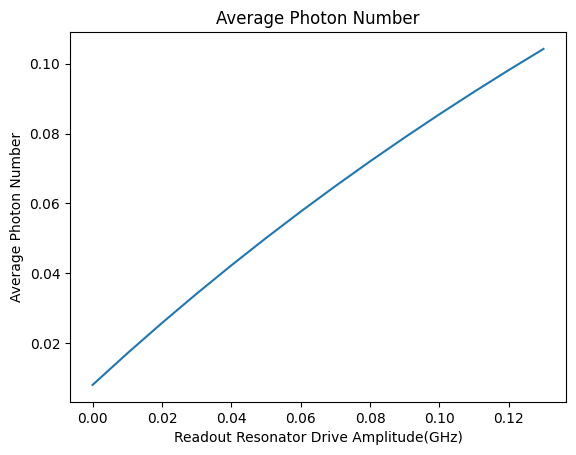

In [263]:
# Plot Results

plt.plot(nth_list, n_list)

plt.title('Average Photon Number')
plt.xlabel('Readout Resonator Drive Amplitude(GHz)')
plt.ylabel('Average Photon Number')

## Ramsey (n_th = 0)

In [150]:
# constant
N = 2

n_th = 0
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [151]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.00798522851099307


Text(0, 0.5, 'Z Expectation Value')

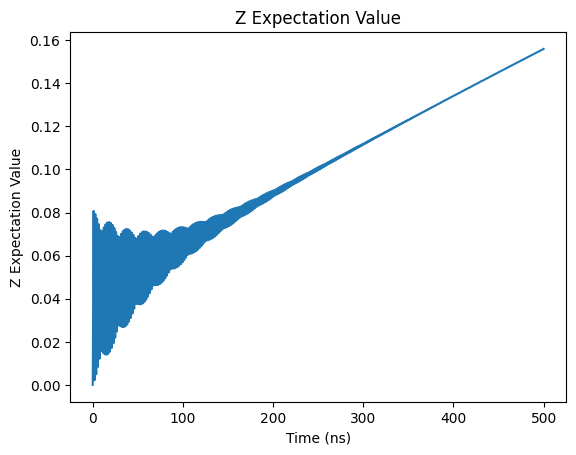

In [152]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [153]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.54845817e-01,  9.95871091e-01,  3.89892242e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

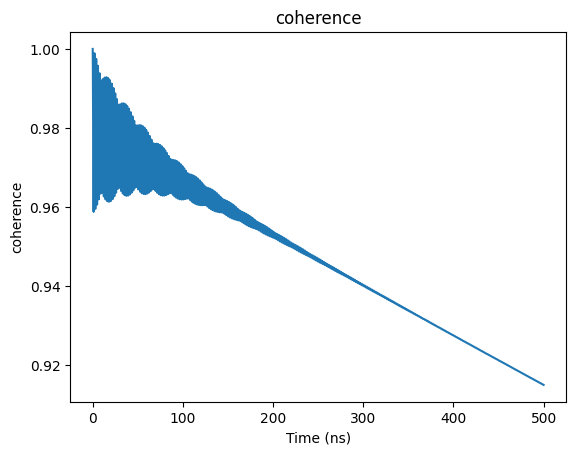

In [154]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

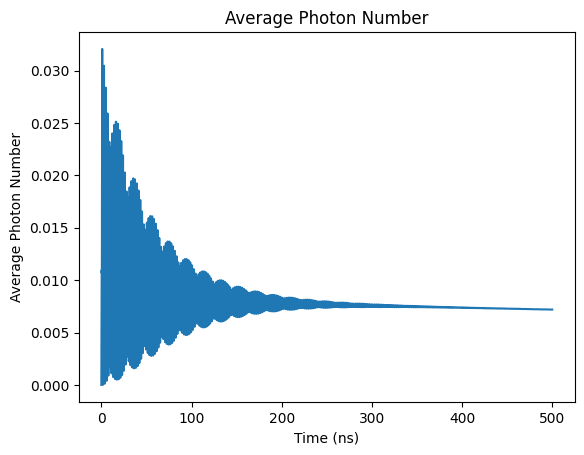

In [155]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

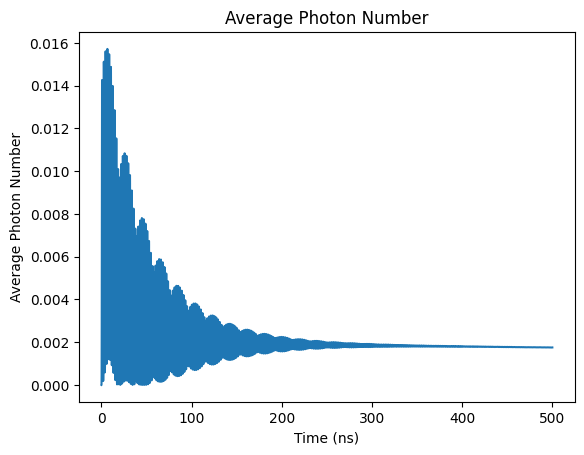

In [156]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

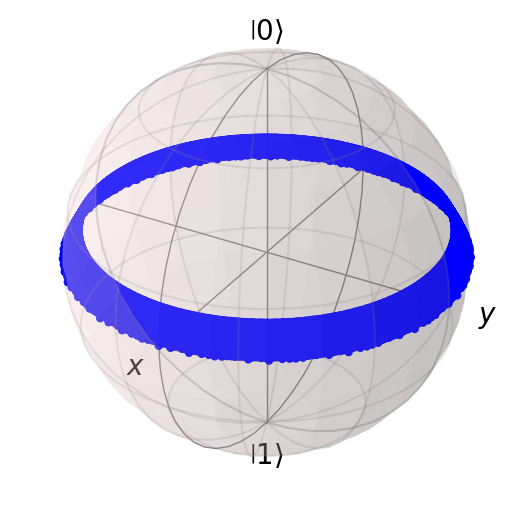

In [157]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.01)

In [158]:
# constant
N = 2

n_th = 0.01
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [159]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.017015670421969924


Text(0, 0.5, 'Z Expectation Value')

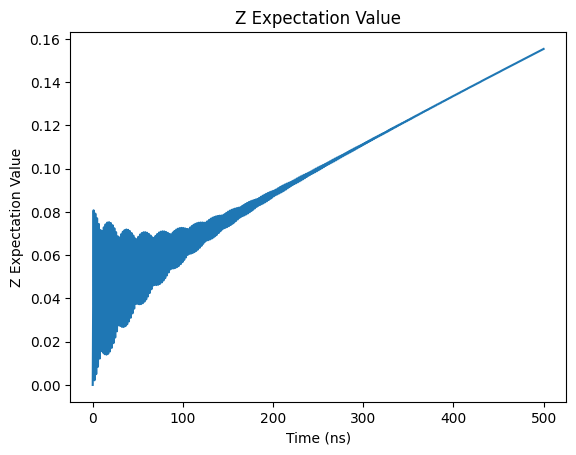

In [160]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [161]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.67517216e-01,  1.00823949e+00,  3.96426619e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

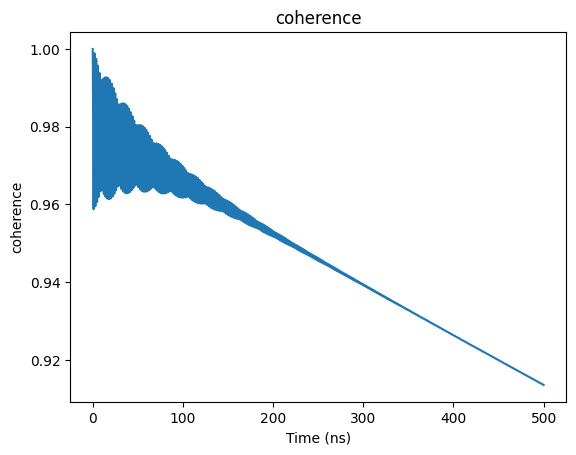

In [162]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

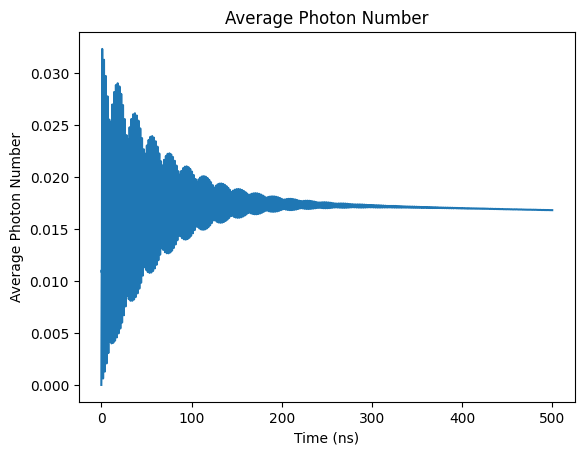

In [163]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

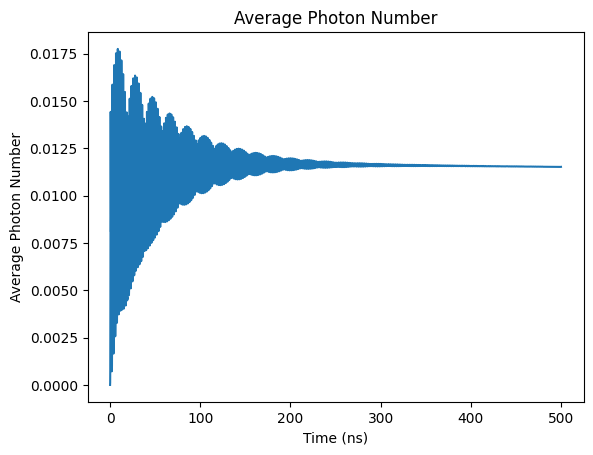

In [164]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

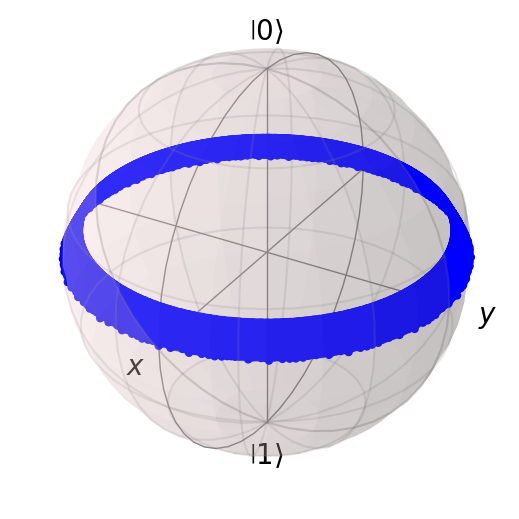

In [165]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.02)

In [166]:
# constant
N = 2

n_th = 0.02
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [167]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.025721601622787638


Text(0, 0.5, 'Z Expectation Value')

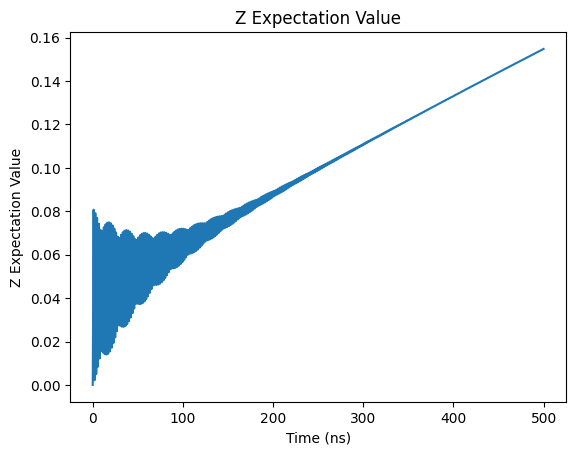

In [168]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [169]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.77752018e-01,  1.01817714e+00,  4.01893889e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

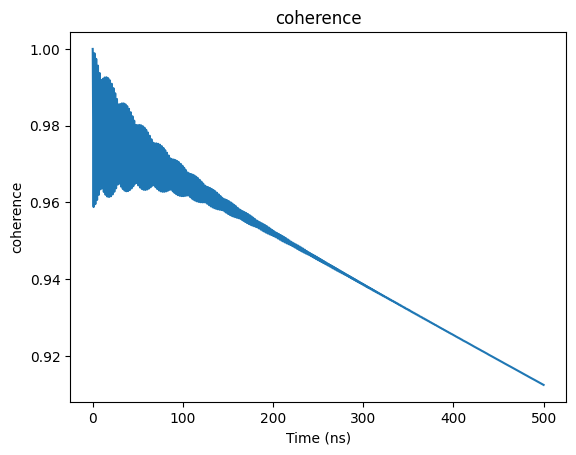

In [170]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

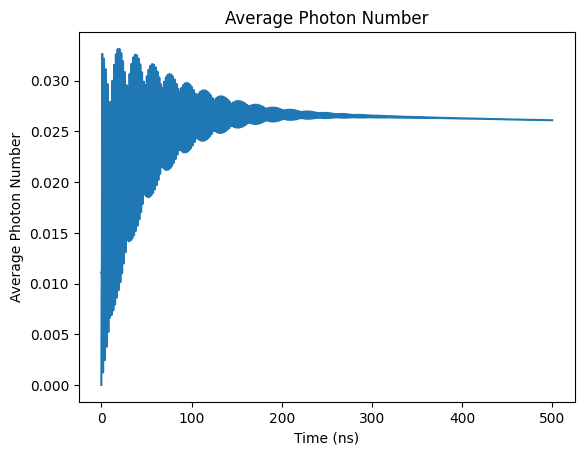

In [171]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

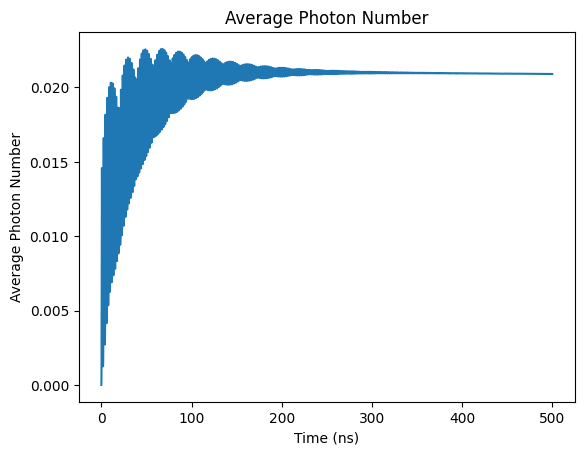

In [172]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

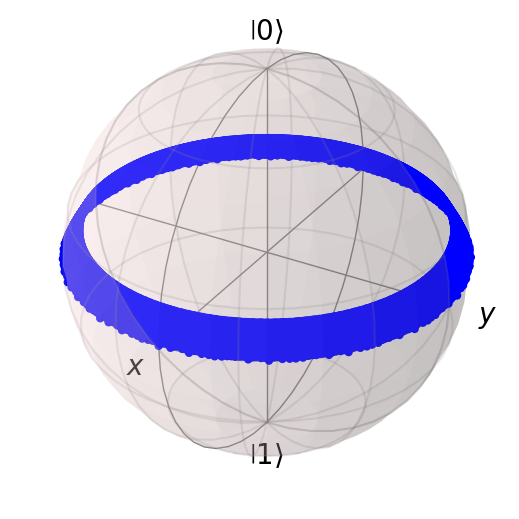

In [173]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.03)

In [174]:
# constant
N = 2

n_th = 0.03
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [175]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.034120124844334354


Text(0, 0.5, 'Z Expectation Value')

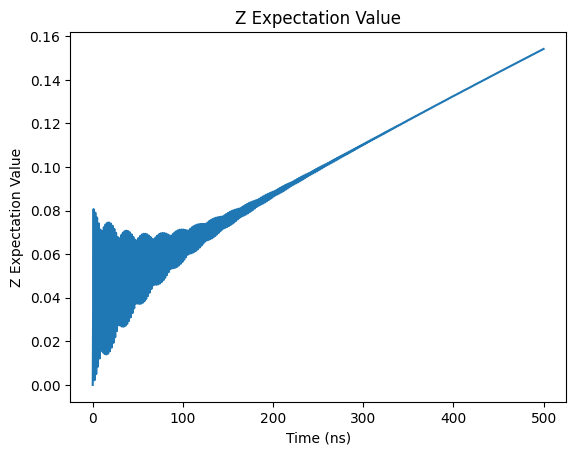

In [176]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [177]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.85570764e-01,  1.02570455e+00,  4.06297275e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

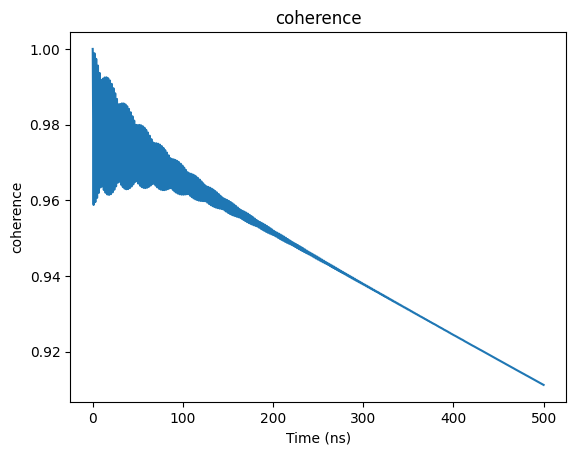

In [178]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

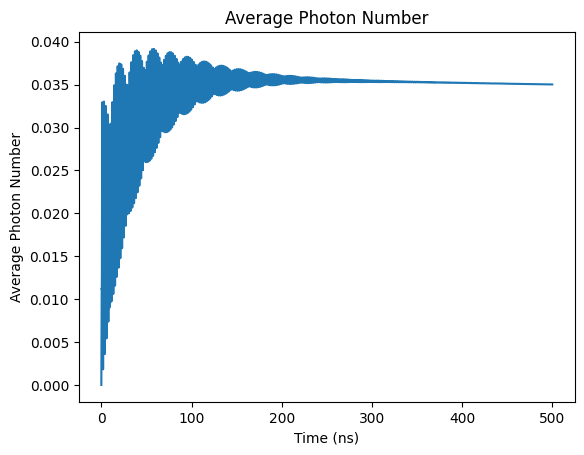

In [179]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

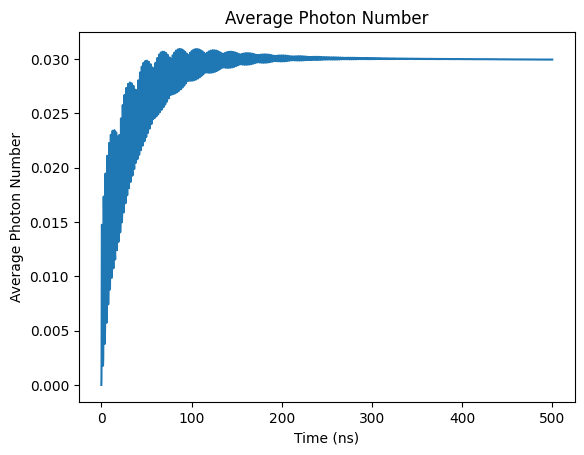

In [180]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

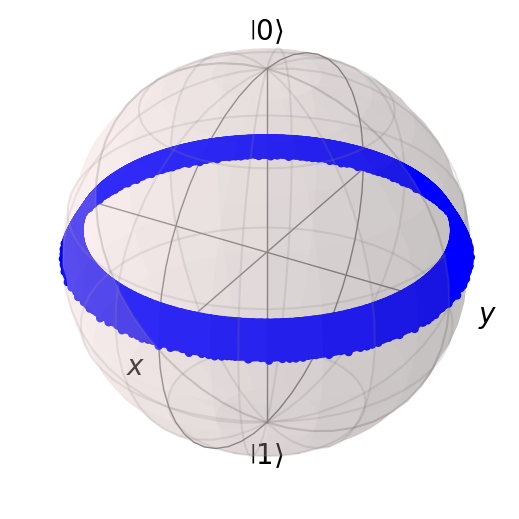

In [181]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.04)

In [182]:
# constant
N = 2

n_th = 0.04
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [183]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.0422271679665512


Text(0, 0.5, 'Z Expectation Value')

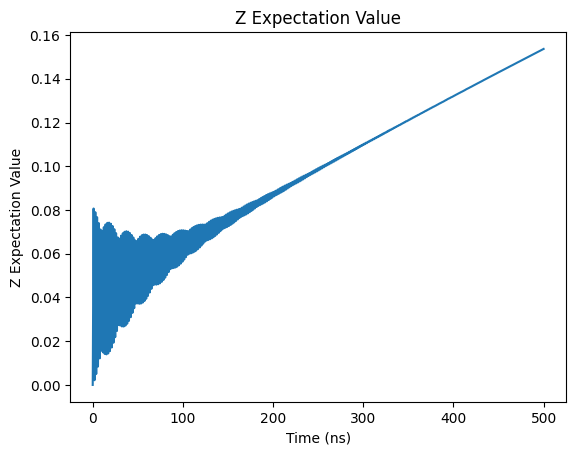

In [184]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [185]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.91030835e-01,  1.03087907e+00,  4.09656478e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

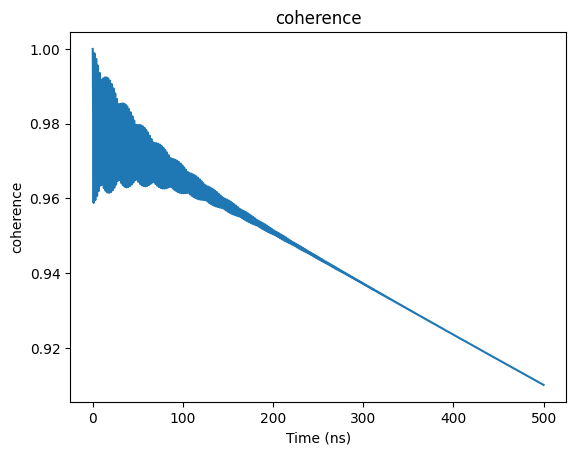

In [186]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

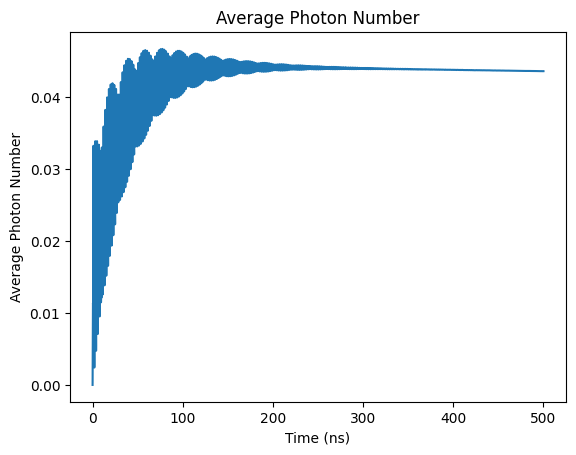

In [187]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

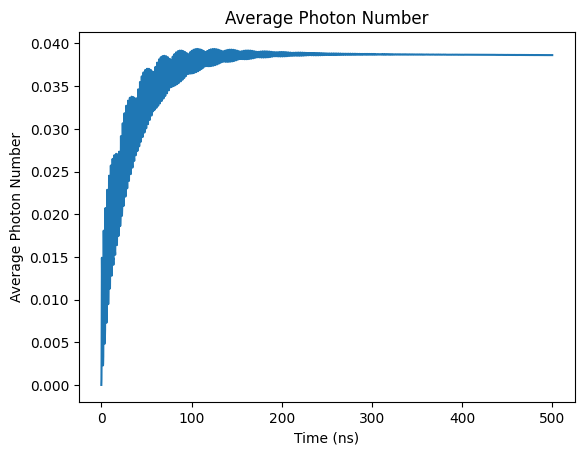

In [188]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

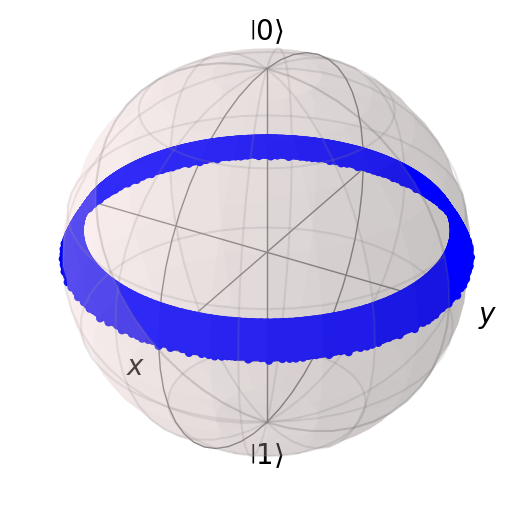

In [189]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.05)

In [190]:
# constant
N = 2

n_th = 0.05
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [191]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.05005758261153177


Text(0, 0.5, 'Z Expectation Value')

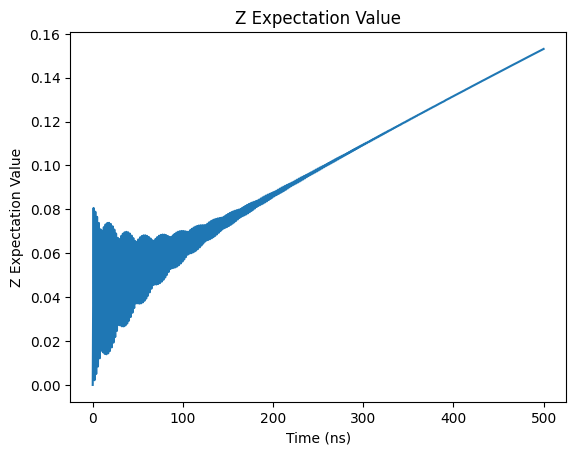

In [192]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [193]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.94220679e-01,  1.03378908e+00,  4.12005267e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

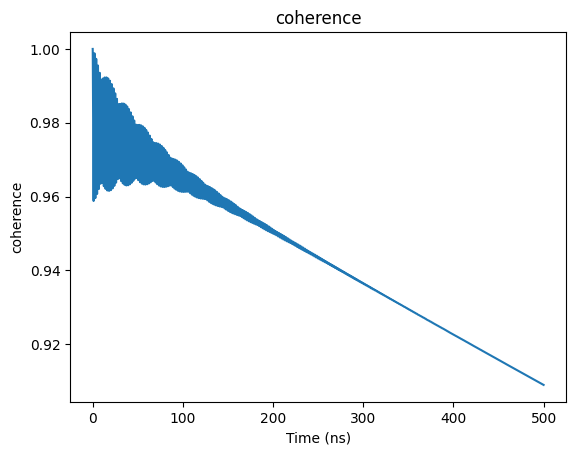

In [194]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

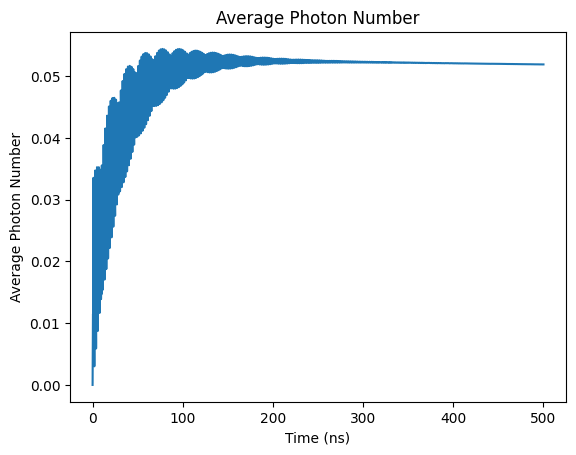

In [195]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

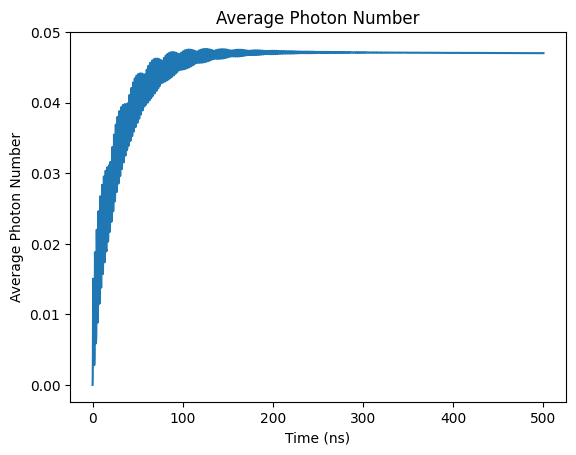

In [196]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

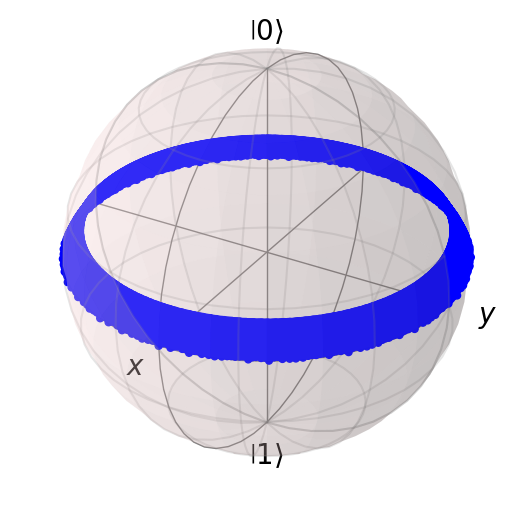

In [197]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.06)

In [198]:
# constant
N = 2

n_th = 0.06
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [199]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.057625233036684764


Text(0, 0.5, 'Z Expectation Value')

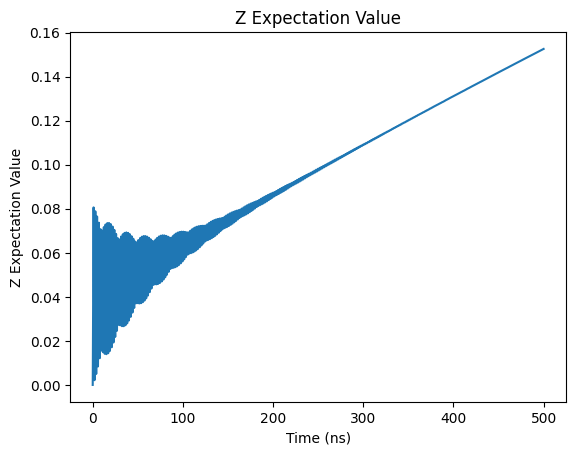

In [200]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [201]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.95255772e-01,  1.03455000e+00,  4.13389802e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

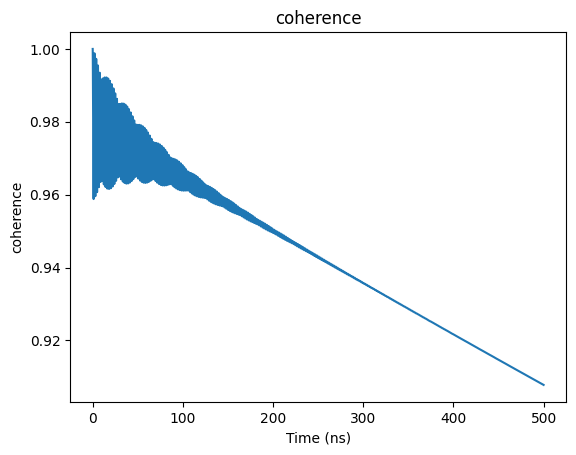

In [202]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

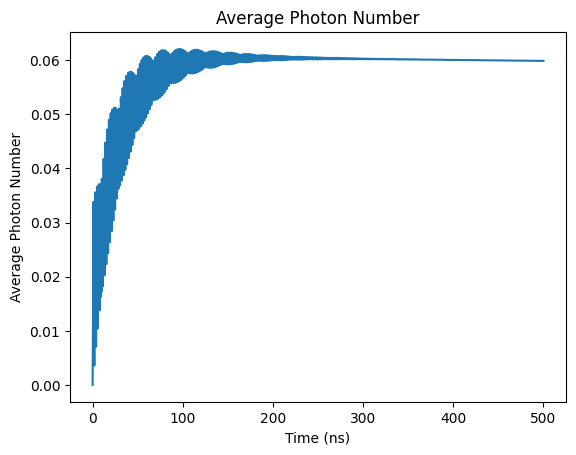

In [203]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

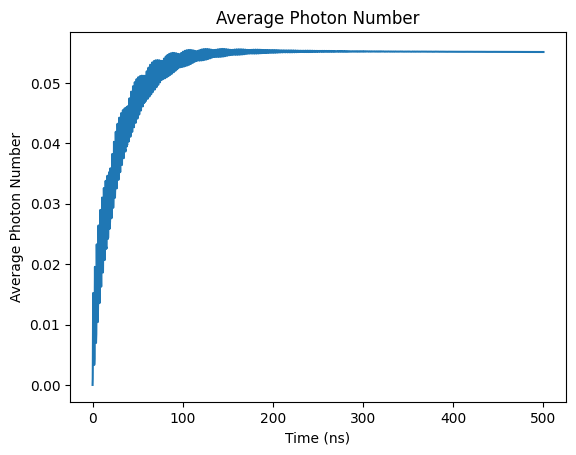

In [204]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

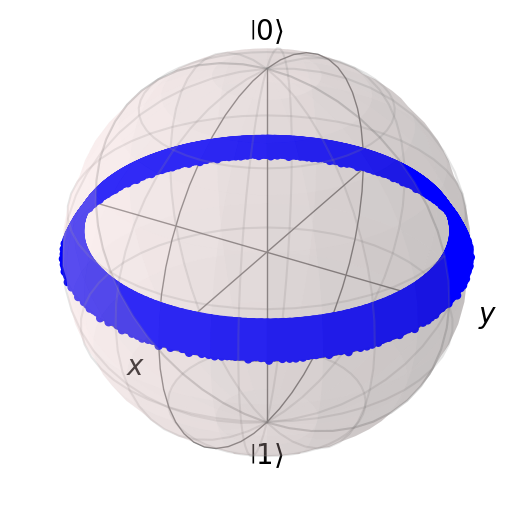

In [205]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.07)

In [206]:
# constant
N = 2

n_th = 0.07
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [207]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.06494307641510726


Text(0, 0.5, 'Z Expectation Value')

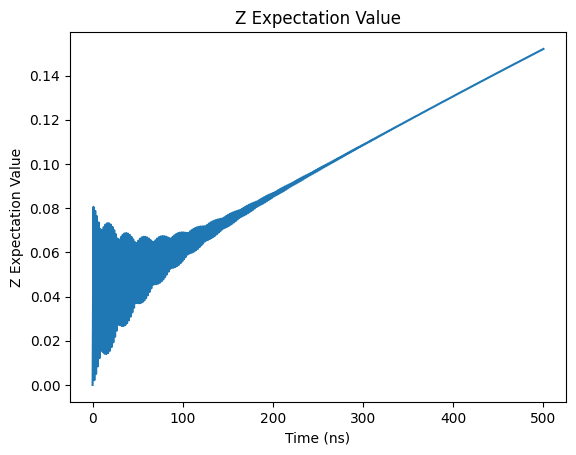

In [208]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [209]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.94271345e-01,  1.03329698e+00,  4.13865498e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

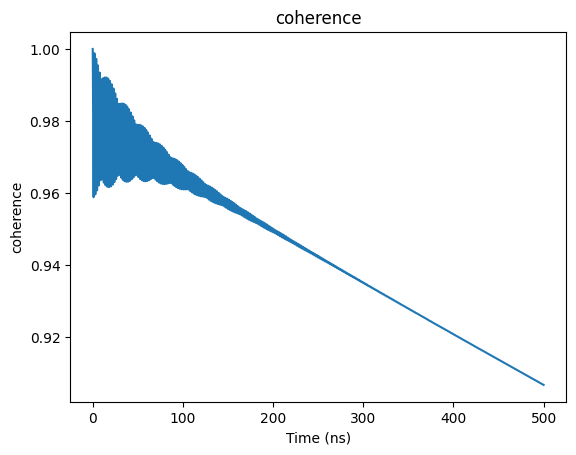

In [210]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

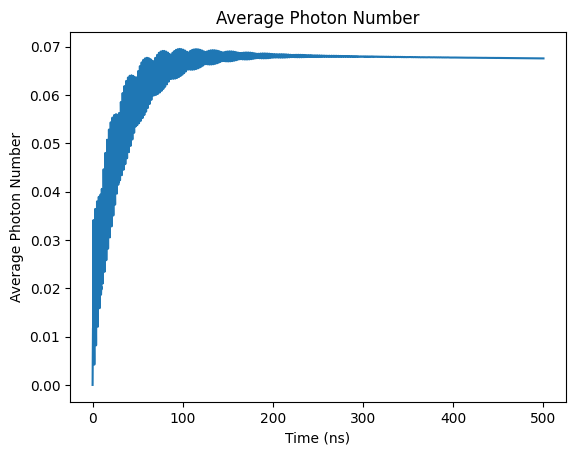

In [211]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

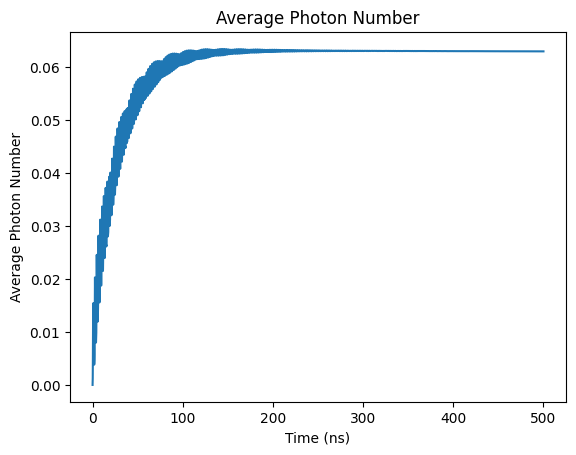

In [212]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

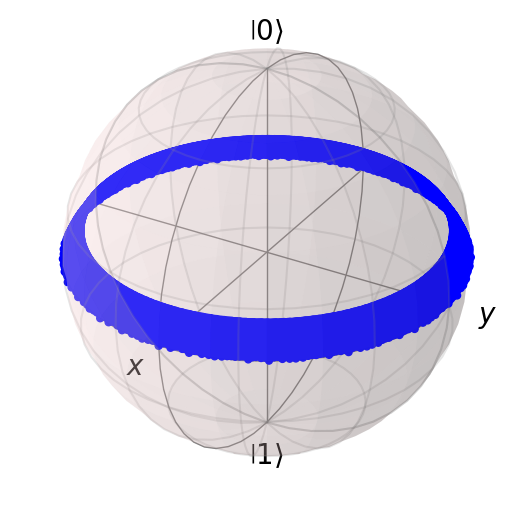

In [213]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.08)

In [214]:
# constant
N = 2

n_th = 0.08
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [215]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.07202323545446147


Text(0, 0.5, 'Z Expectation Value')

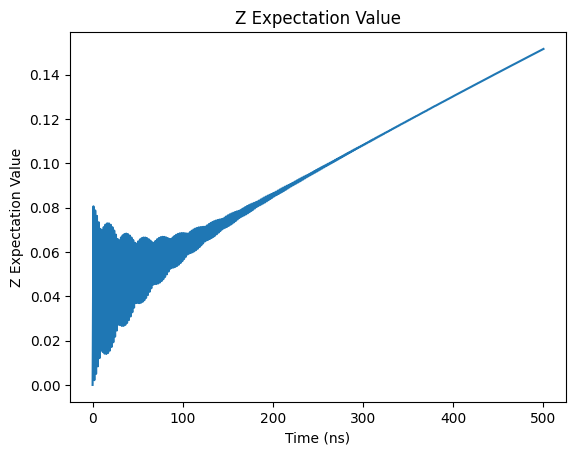

In [216]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [217]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.91419834e-01,  1.03018237e+00,  4.13495945e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

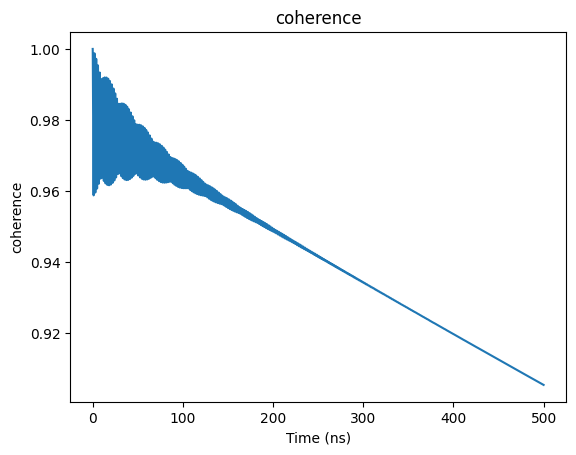

In [218]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

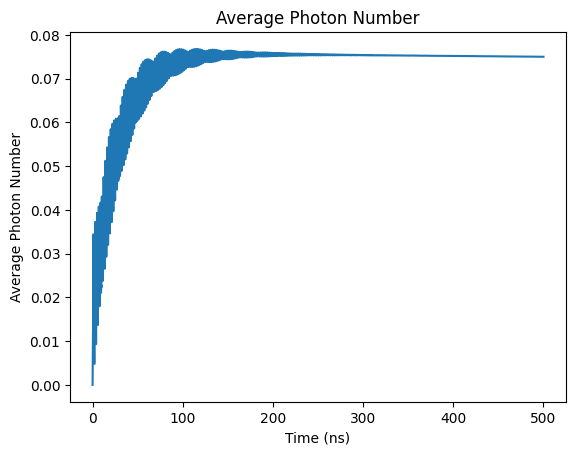

In [219]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

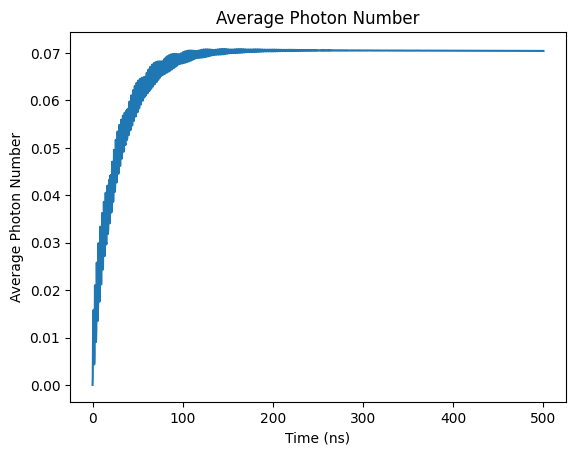

In [220]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

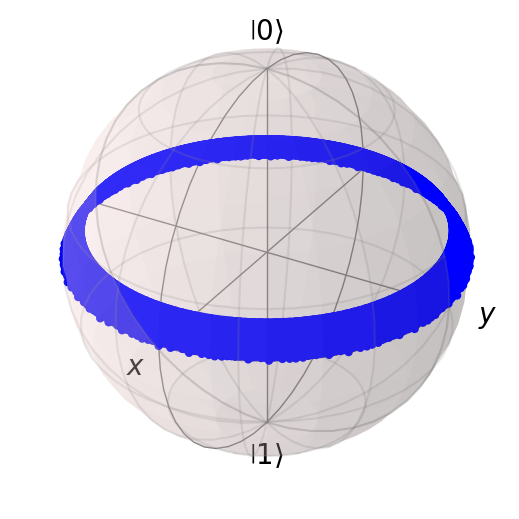

In [221]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.09)

In [222]:
# constant
N = 2

n_th = 0.09
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [223]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.0788770641883869


Text(0, 0.5, 'Z Expectation Value')

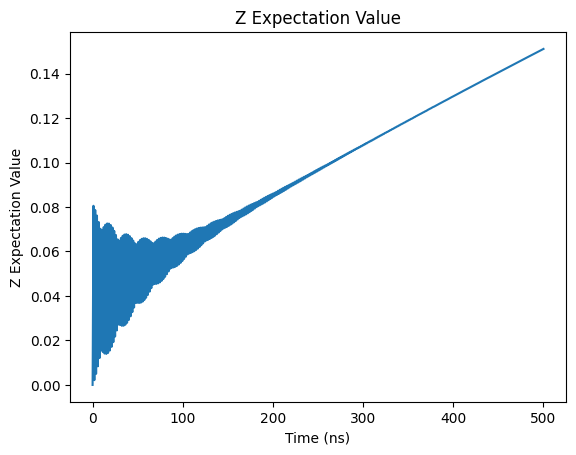

In [224]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [225]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.86861779e-01,  1.02536662e+00,  4.12348910e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

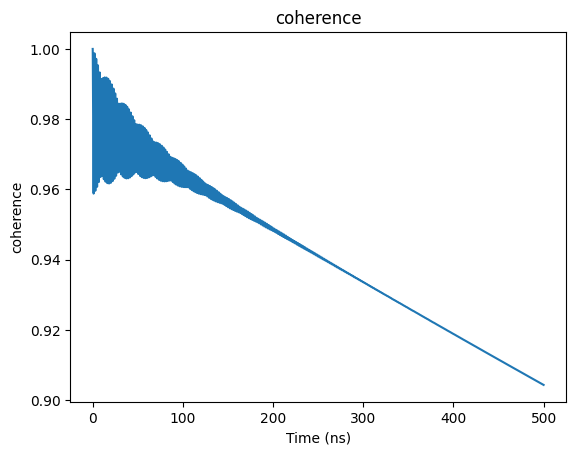

In [226]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

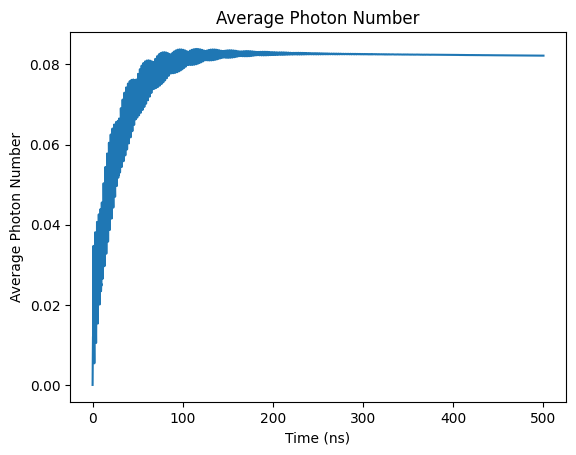

In [227]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

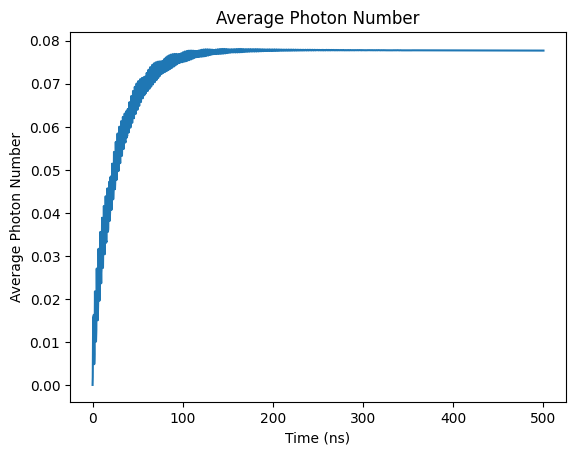

In [228]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

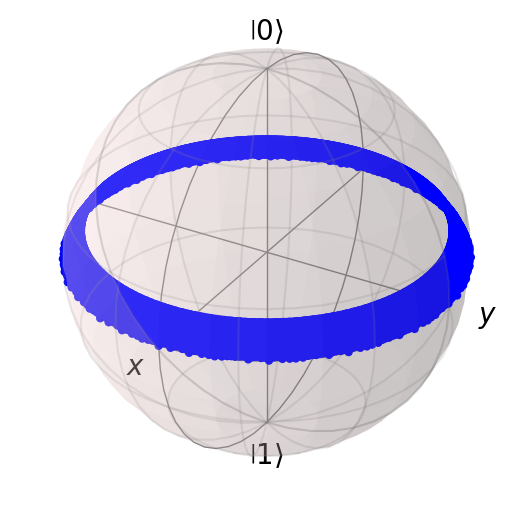

In [229]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.10)

In [230]:
# constant
N = 2

n_th = 0.10
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [231]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.08551520767305751


Text(0, 0.5, 'Z Expectation Value')

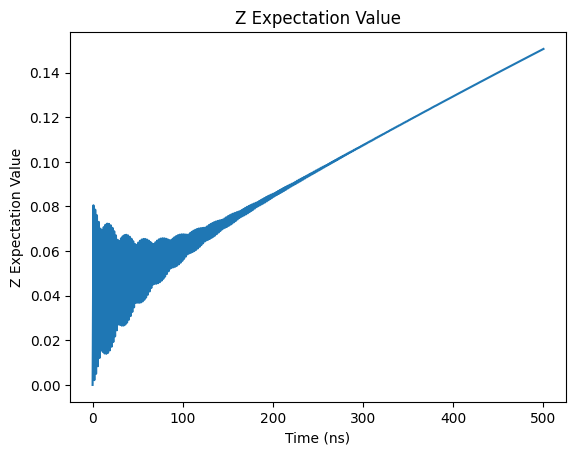

In [232]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [233]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.80765333e-01,  1.01901780e+00,  4.10496125e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

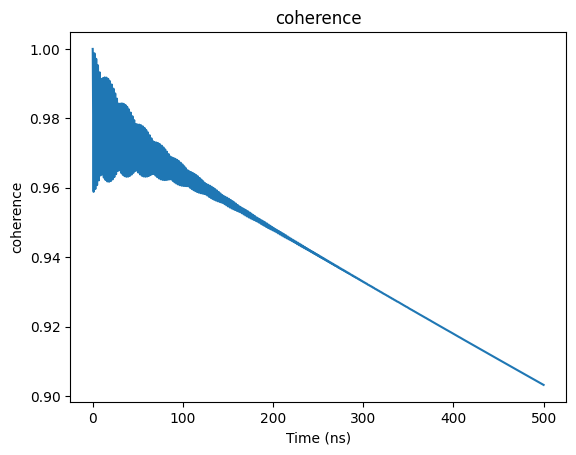

In [234]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

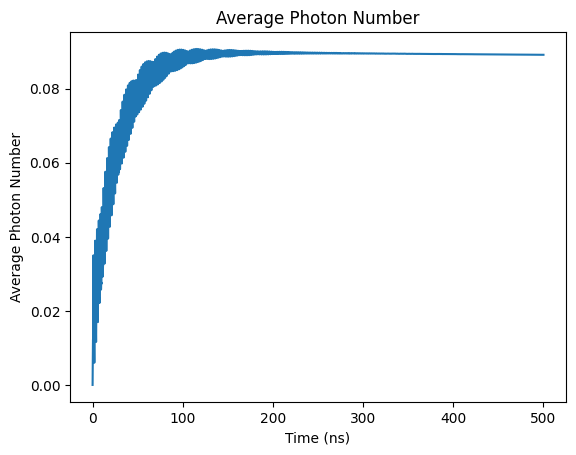

In [235]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

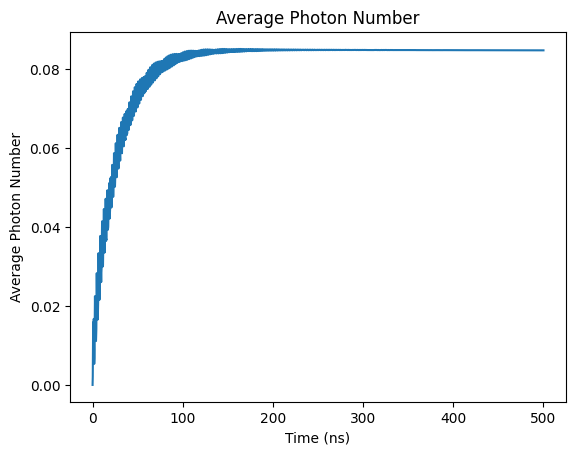

In [236]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

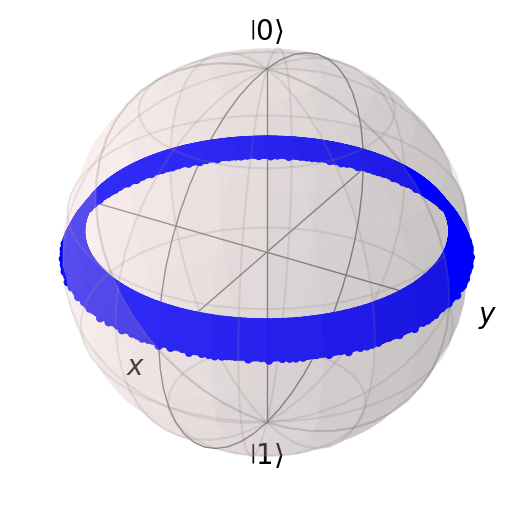

In [237]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.11)

In [238]:
# constant
N = 2

n_th = 0.11
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [239]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.09194765623366859


Text(0, 0.5, 'Z Expectation Value')

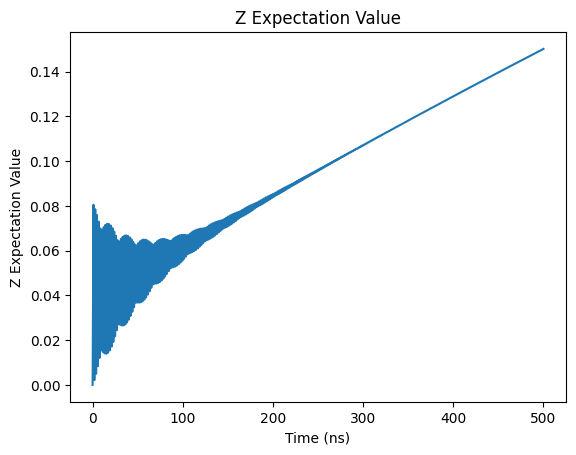

In [240]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [241]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.73297496e-01,  1.01130281e+00,  4.08009376e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

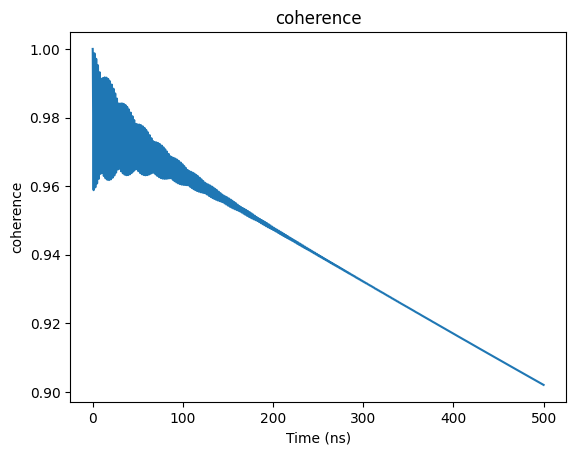

In [242]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

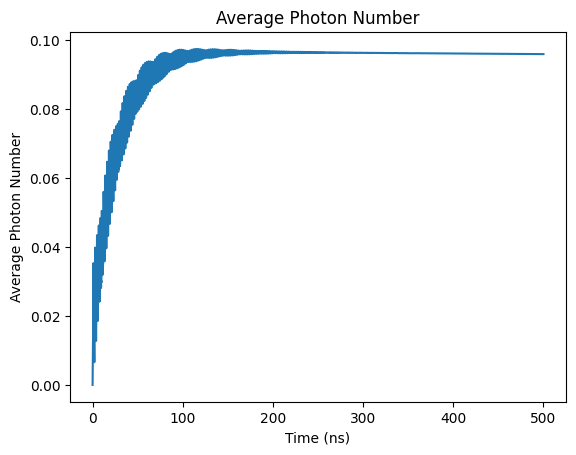

In [243]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

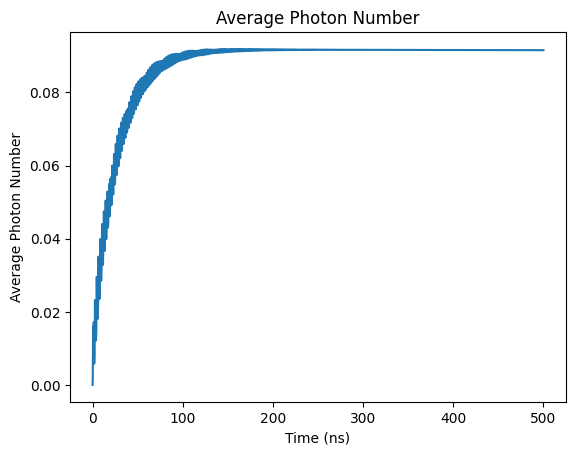

In [244]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

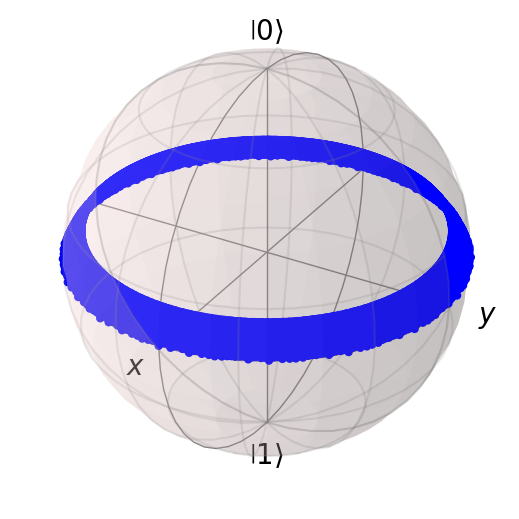

In [245]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.12)

In [246]:
# constant
N = 2

n_th = 0.12
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [247]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.09818379482936314


Text(0, 0.5, 'Z Expectation Value')

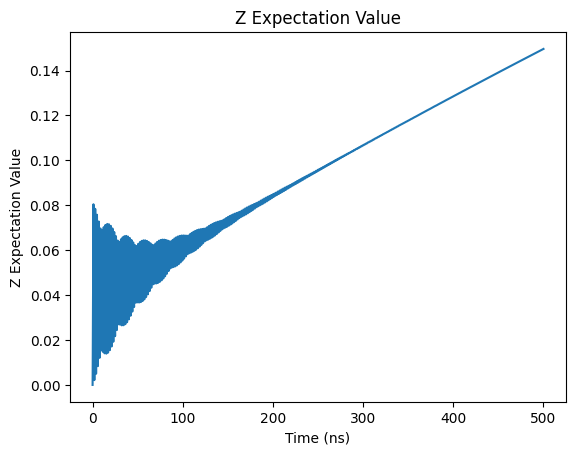

In [248]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [249]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.64622878e-01,  1.00238615e+00,  4.04959932e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

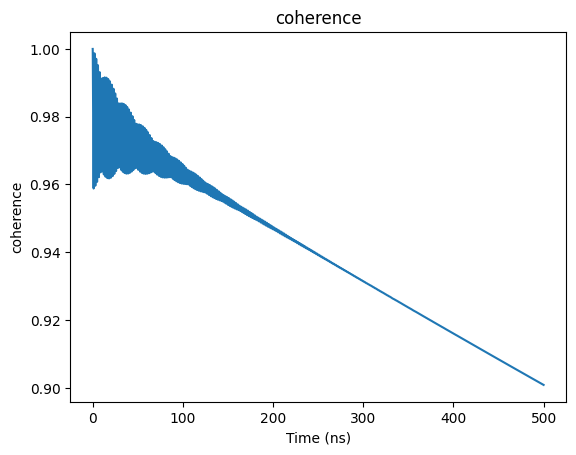

In [250]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

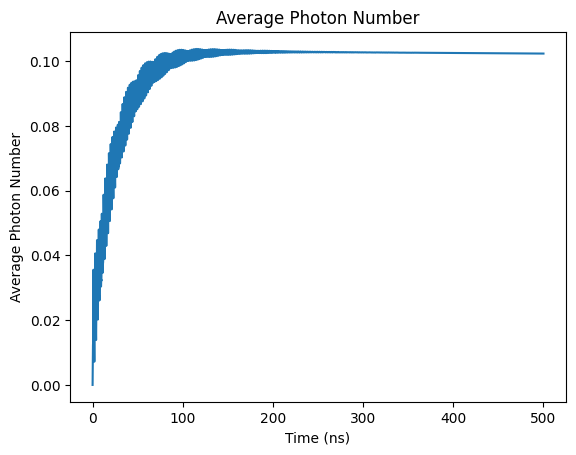

In [251]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

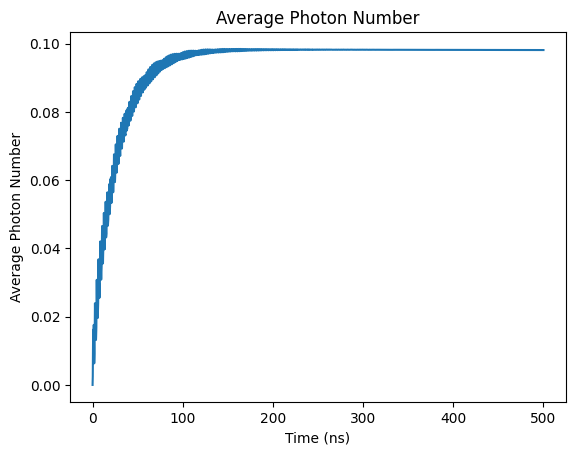

In [252]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

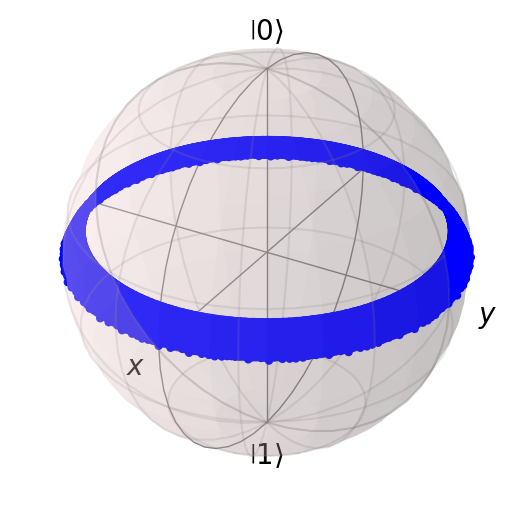

In [253]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

## Ramsey (n_th = 0.13)

In [254]:
# constant
N = 2

n_th = 0.13
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

In [255]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))
n_list.append(np.mean(result.expect[4]))

0.1042324480387417


Text(0, 0.5, 'Z Expectation Value')

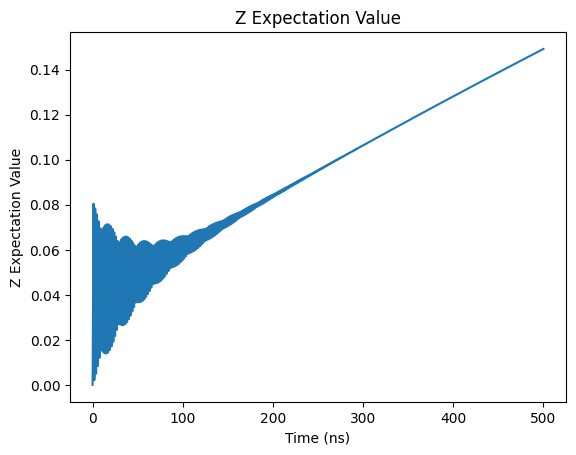

In [256]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [257]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-9.54902773e-01,  9.92429028e-01,  4.01418103e+03])

Measured $ T_1 = 1.6196 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

Text(0, 0.5, 'coherence')

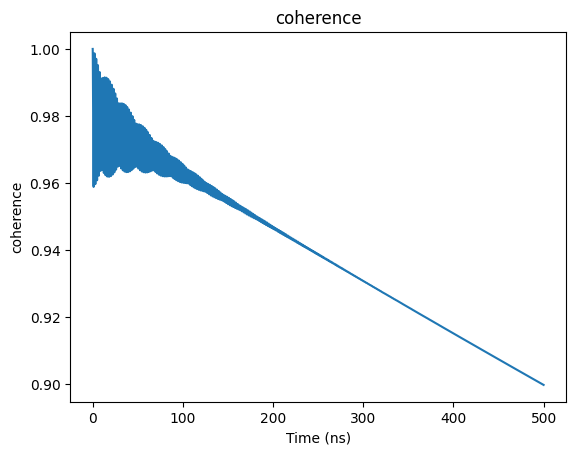

In [258]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

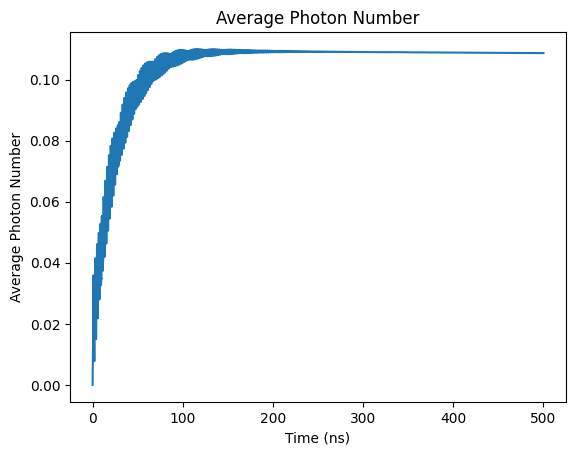

In [259]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

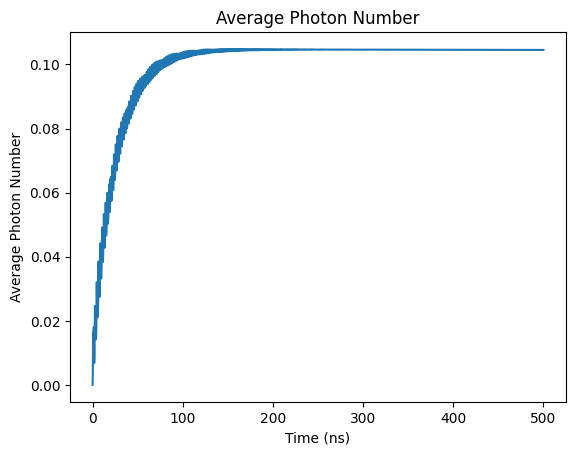

In [260]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

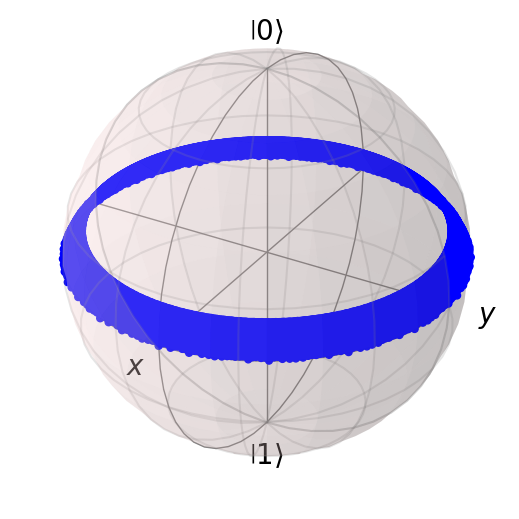

In [261]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

# Dynamical Decoupling Bloch Sphere Approach (Thermal Photon Case)

With Purcell Filter

Evolution time 500ns

In [381]:
tot_coherence_list = []

In [ ]:
tot_coherence_list

## Readout Resonator THermal Photon Number $ n_{th} = 0.02 $

Evolution time 500ns

In [382]:
# constant
N = 2

n_th = 0.01
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [383]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.017015670421969924


Text(0, 0.5, 'Z Expectation Value')

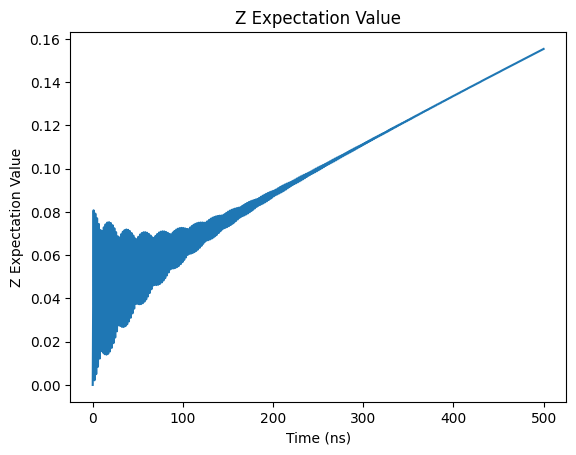

In [384]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

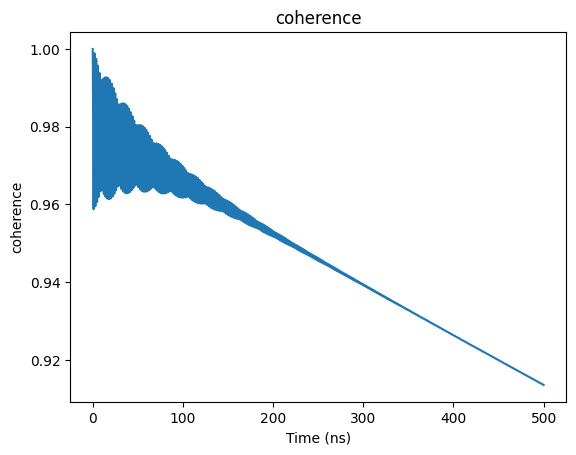

In [385]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

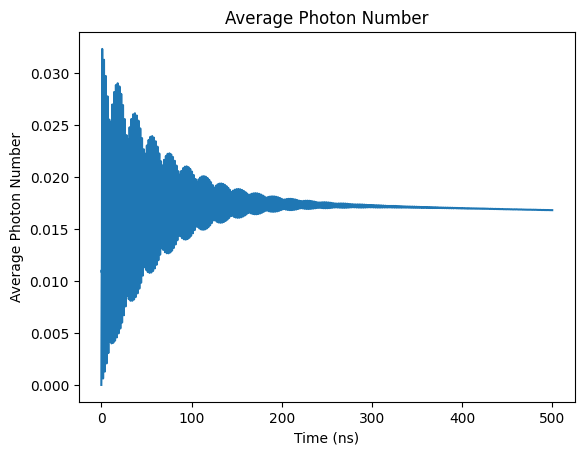

In [386]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

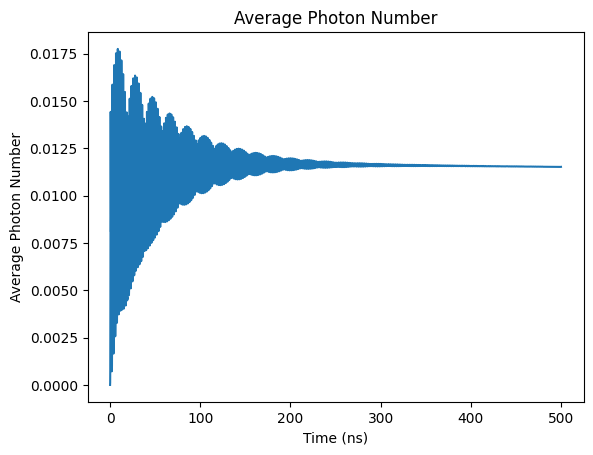

In [387]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

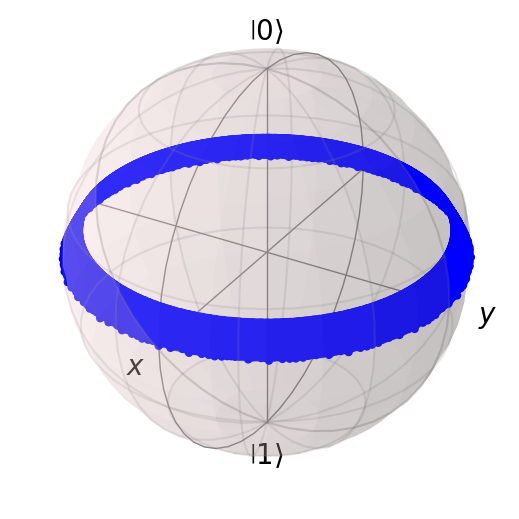

In [388]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [389]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [390]:
# Simulation

result = mesolve(
    [H0, [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.017722364880221497


Text(0, 0.5, 'Z Expectation Value')

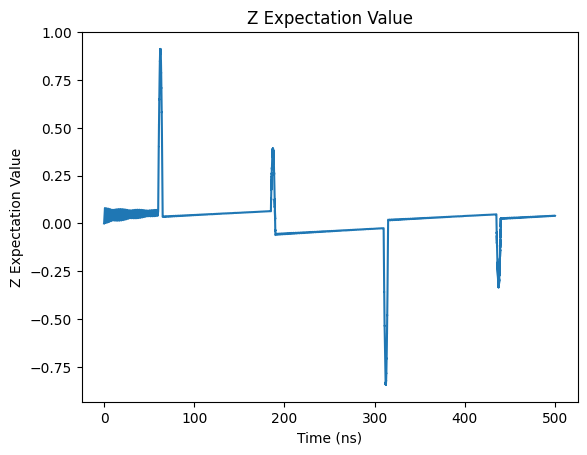

In [391]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

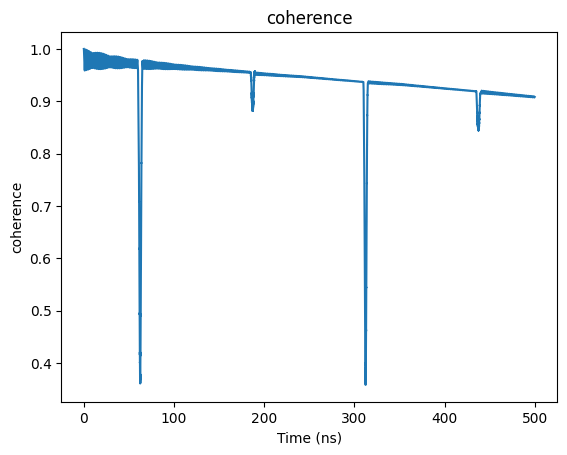

In [392]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

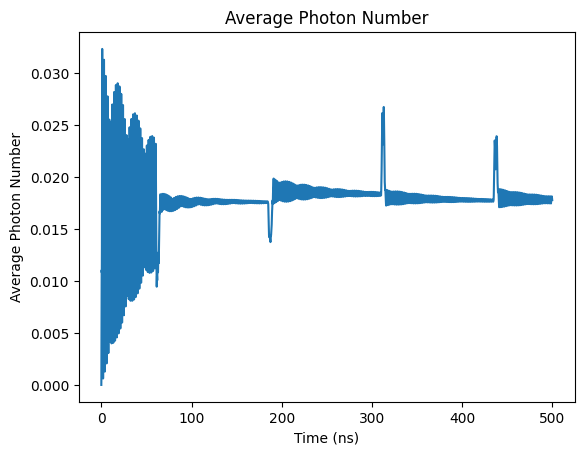

In [393]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

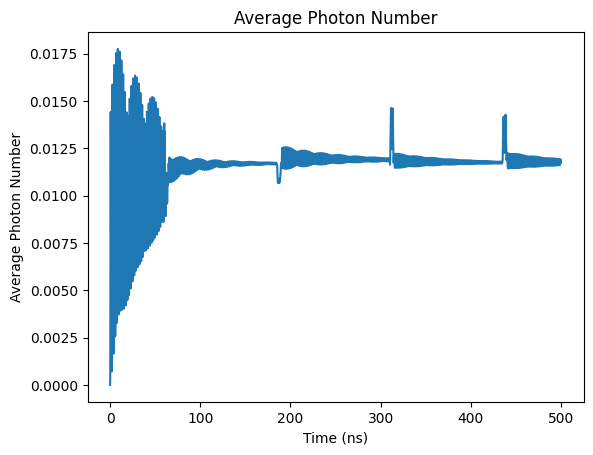

In [394]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

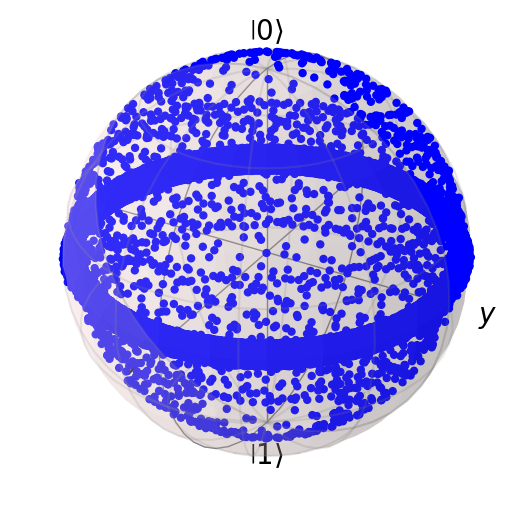

In [395]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [396]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [397]:
# Simulation

result = mesolve(
    [H0, [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

0.017757205372508716


Text(0, 0.5, 'Z Expectation Value')

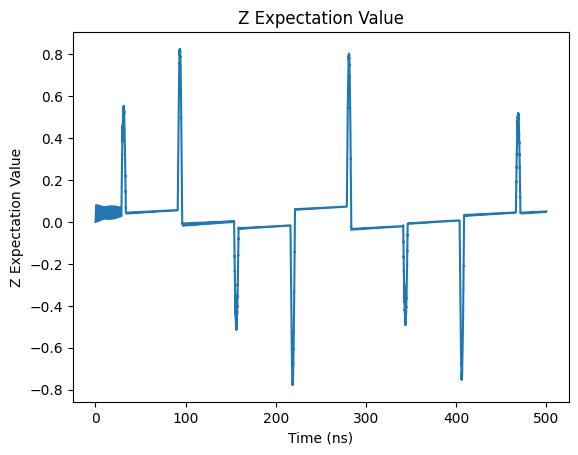

In [398]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'coherence')

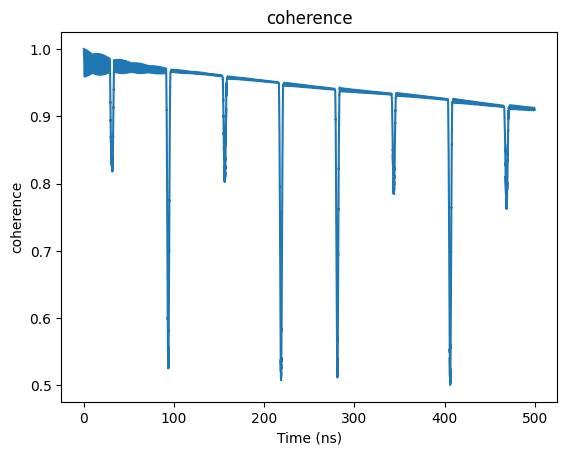

In [399]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

Text(0, 0.5, 'Average Photon Number')

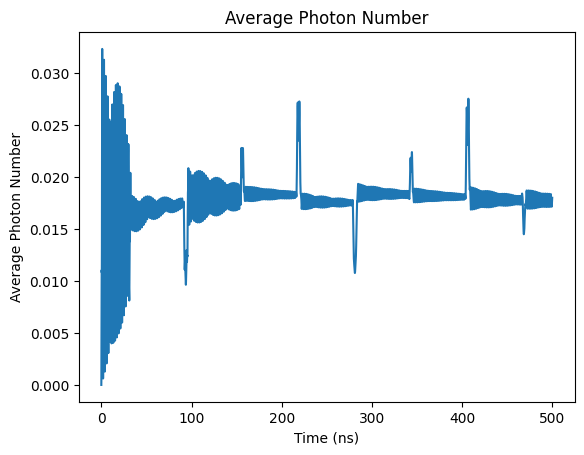

In [400]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

Text(0, 0.5, 'Average Photon Number')

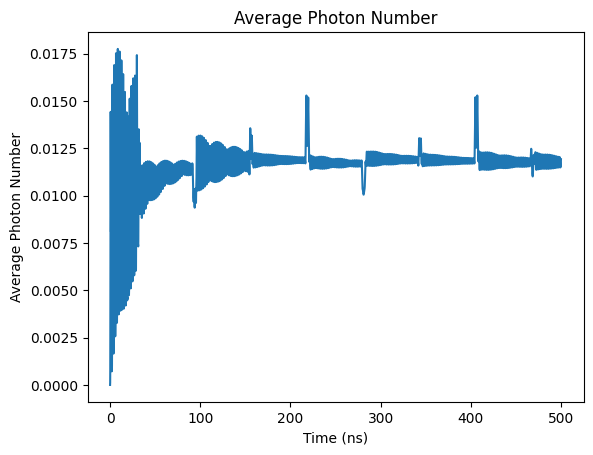

In [401]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

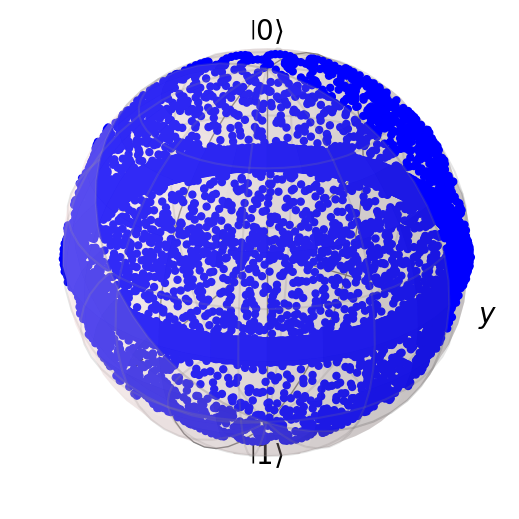

In [402]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [403]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator THermal Photon Number $ n_{th} = 0.04 $

Evolution time 500ns

In [ ]:
# constant
N = 2

n_th = 0.04
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator THermal Photon Number $ n_{th} = 0.06 $

Evolution time 500ns

In [ ]:
# constant
N = 2

n_th = 0.06
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator THermal Photon Number $ n_{th} = 0.08 $

Evolution time 500ns

In [ ]:
# constant
N = 2

n_th = 0.09
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)

## Readout Resonator THermal Photon Number $ n_{th} = 0.10 $

Evolution time 500ns

In [ ]:
# constant
N = 2

n_th = 0.12
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
# H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite


tlist = np.linspace(0, 500, 50000)
T_end_q = 500

coherence_list = []

### Ramsey

In [ ]:
# Simulation

N_seq = 0

result = mesolve(
    [H0, [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY4

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY8

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### XY16

In [ ]:
# Simulation

result = mesolve(
    [H0, [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f*(n_th+1)) * tensor(qeye(2), qeye(N), b), np.sqrt(kappa_f*(n_th)) * tensor(qeye(2), qeye(N), b.dag())],
    args = {'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

print(np.mean(result.expect[4]))

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z Expectation Value')
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

In [ ]:
# Plot Results

plt.plot(tlist, 2*np.abs(result.expect[3]), label = 'average photon number 0.0005')

plt.title('coherence')
plt.xlabel('Time (ns)')
plt.ylabel('coherence')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Average Photon Number')
plt.xlabel('Time (ns)')
plt.ylabel('Average Photon Number')

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

In [ ]:
avg = 0
for i in range(100):
  avg = avg + 2*np.abs(result.expect[3][-1-i])
avg = avg/100

coherence_list.append(avg)

### Print Coherence

In [ ]:
coherence_list

In [ ]:
tot_coherence_list.append(coherence_list)